In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from dataclasses import dataclass
from typing import Tuple


from scipy.optimize import minimize
from scipy.spatial.distance import cdist
import odor_stat_calculations as osc
from plume_sim import OdorPredictor
from scipy.stats import kurtosis
import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import mpl_functions
from scipy.ndimage import gaussian_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import gaussian_kde
from itertools import groupby
from operator import itemgetter
import multiprocessing as mp

%load_ext autoreload
%autoreload 2

2024-12-28 15:23:23.324332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-28 15:23:23.335690: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-28 15:23:23.339087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-28 15:23:24.064213: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dfres = pd.read_hdf('/home/gorilla/An/data/WindyMASigned.h5') 

In [3]:
index = osc.get_index(dfres.odor,4.5)
whiff_initiation_points = [sub[0] for sub in index]
dfres['whiff_flag'] = 0

# Set 1 for the specified indices in the 'whiff_flag' column
dfres.iloc[whiff_initiation_points, dfres.columns.get_loc('whiff_flag')] = 1

dfres['distance_along_streakline']=dfres.distance_along_streakline*dfres.xsign
dfres['nearest_from_streakline']=dfres.nearest_from_streakline*dfres.ysign



In [4]:
def avg_distance(df,index,dat): #input ; location ; storage
    i = 0
    distance_along_streakline = []
    nearest_from_streakline = []
    while i<len(index):
        distance_along_streakline.append(np.mean(df.distance_along_streakline[index[i]]))
        nearest_from_streakline.append(np.mean(df.nearest_from_streakline[index[i]]))
        i+=1
    dat['avg_distance_along_streakline']= distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def get_index_nowhiff(data, th):
    idx = [i for i, value in enumerate(data) if value < th]
    index = [list(map(itemgetter(1), g)) for k, g in groupby(enumerate(idx), lambda ix: ix[0] - ix[1])]
    return index

def avg_distance_nowhiff(df, idx, dat):
    distance_along_streakline = []
    nearest_from_streakline = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            distance_along_streakline.append(np.mean(df['distance_along_streakline'].iloc[indices]))
            nearest_from_streakline.append(np.mean(df['nearest_from_streakline'].iloc[indices]))
        else:
            distance_along_streakline.append(np.nan)
            nearest_from_streakline.append(np.nan)

    dat['avg_distance_along_streakline'] = distance_along_streakline
    dat['avg_nearest_from_streakline'] = nearest_from_streakline

def wc_wsd_nowhiff(df, idx, dat):
    wc_nowhiff = []
    std_dev_nowhiff = []
    for indices in idx:
        if indices:  # Check if indices list is not empty
            wc_nowhiff.append(np.mean(df['odor'].iloc[indices]))
            std_dev_nowhiff.append(np.std(df['odor'].iloc[indices]))
        else:
            wc_nowhiff.append(np.nan)
            std_dev_nowhiff.append(np.nan)

    dat['wc_nowhiff'] = wc_nowhiff
    dat['wsd_nowhiff'] = std_dev_nowhiff

def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

th = 4.5
np.seterr(divide='ignore')
index = osc.get_index(dfres.odor,th)
index_nowhiff = get_index_nowhiff(dfres.odor,th)
fdf = pd.DataFrame()
fdf_nowhiff=pd.DataFrame()

cal_stat(dfres,index,fdf)
avg_distance(dfres, index, fdf)
wc_wsd_nowhiff(dfres, index_nowhiff,fdf_nowhiff)
avg_distance_nowhiff(dfres,index_nowhiff,fdf_nowhiff)

<!-- #### Likelihood of Estimation of probability - Gaussian Prob + Real world -  -->

Optimal Parameters:
A = 0.011745770323211514
x0 = 0.0
y0 = 0.0
sigma_x = 19.874345900298934
sigma_y = 1.0
theta = 3.1281874790251507


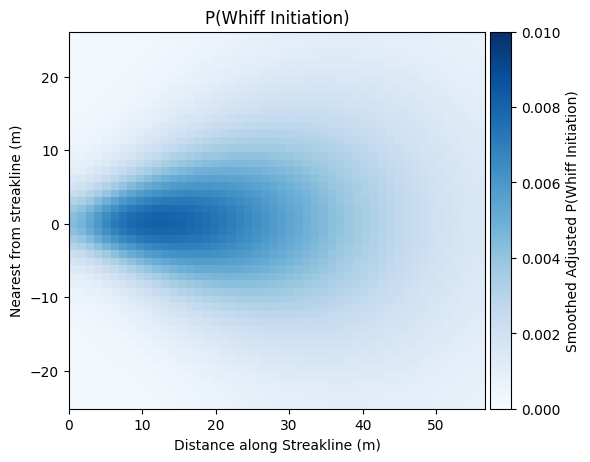

In [5]:
n_bins_x=n_bins_y=50
heatmap_whiff, xedges, yedges = np.histogram2d(dfres['distance_along_streakline'], 
                                               dfres['nearest_from_streakline'], 
                                               bins=[n_bins_x, n_bins_y], 
                                               weights=dfres['whiff_flag'])

heatmap_total, _, _ = np.histogram2d(dfres['distance_along_streakline'], 
                                     dfres['nearest_from_streakline'], 
                                     bins=[n_bins_x, n_bins_y])

with np.errstate(divide='ignore', invalid='ignore'):  # Handle division by zero
    heatmap_prob = np.divide(heatmap_whiff, heatmap_total, out=np.zeros_like(heatmap_whiff), where=heatmap_total != 0)


def directional_gaussian_plume(x, y, A, x0, y0, base_sigma_x, base_sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y, damping_factor):
    """Calculate a directional Gaussian plume model with dynamic spread."""
    distance_from_source = np.sqrt((x - x0)**2 + (y - y0)**2)
    sigma_x = base_sigma_x + distance_scale_factor_x * np.sqrt(distance_from_source)
    sigma_y = base_sigma_y + distance_scale_factor_y * distance_from_source 
    
    xp = np.cos(theta) * (x - x0) - np.sin(theta) * (y - y0)
    yp = np.sin(theta) * (x - x0) + np.cos(theta) * (y - y0)

    p = A * np.exp(-((xp)**2 / (2 * sigma_x**2)) - ((yp)**2 / (2 * sigma_y**2))) * np.exp(-damping_factor / (distance_from_source + 1))
    return p

x_centers = (xedges[:-1] + xedges[1:]) / 2
y_centers = (yedges[:-1] + yedges[1:]) / 2
X_centers, Y_centers = np.meshgrid(x_centers, y_centers, indexing='ij')

# Flatten arrays
X_flat = X_centers.flatten()
Y_flat = Y_centers.flatten()
k_obs = heatmap_whiff.flatten()
n_obs = heatmap_total.flatten()

# Exclude bins with zero observations
valid_bins = n_obs > 0
X_flat = X_flat[valid_bins]
Y_flat = Y_flat[valid_bins]
k_obs = k_obs[valid_bins]
n_obs = n_obs[valid_bins]


def negative_log_likelihood(params, x, y, k, n):
    A, x0, y0, sigma_x, sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y,damping_factor = params
    p = directional_gaussian_plume(x, y, A, x0, y0, sigma_x, sigma_y, theta, distance_scale_factor_x,distance_scale_factor_y,damping_factor)
    epsilon = 1e-10
    p = np.clip(p, epsilon, 1 - epsilon)
    ll = k * np.log(p) + (n - k) * np.log(1 - p)
    return -np.sum(ll)


# initial_params = [1.0, 0.0, 0.0, 50, 5, 0.0, 0.01, 0.1] # A, x0, y0, sigma_x, sigma_y, theta, dist_scale_x, dist_scale_y
# Original had sigma_y around 0.43, let's start a bit higher but keep the plume shape
initial_params = [1.0, 0.0, 0.0, 30, 1.5, 0.0, 0.6, 0.4, 0.8]  # Increased sigma_y from ~0.43 to 1.5

bounds = [
    (0, 1),    # A ≥ 0
    (0, 0),    # x0 unbounded
    (0, 0),    # y0 unbounded
    (1e-5, None), # sigma_x ≥ 1e-5
    (1.0, 2.0),   # sigma_y - modest range for thicker but not blob-like spread
    (0, np.pi),   # theta
    (0,1),
    (0.3,0.5),    # y scaling factor - keeping it moderate
    (0.5,2)
]
# Perform the optimization
result = minimize(
    negative_log_likelihood,
    initial_params,
    args=(X_flat, Y_flat, k_obs, n_obs),
    bounds=bounds,
    method='L-BFGS-B'
)

# Extract optimal parameters
optimal_params = result.x
print("Optimal Parameters:")
print(f"A = {optimal_params[0]}")
print(f"x0 = {optimal_params[1]}")
print(f"y0 = {optimal_params[2]}")
print(f"sigma_x = {optimal_params[3]}")
print(f"sigma_y = {optimal_params[4]}")
print(f"theta = {optimal_params[5]}")

# Compute fitted probabilities50
fitted_p = directional_gaussian_plume(
    X_centers, Y_centers, *optimal_params
)
fitted_p_heatmap_spatial = fitted_p.reshape((len(x_centers), len(y_centers)))

def smooth_heatmap_adjustment(heatmap, region_mask, adjustment_factor, sigma=1.0):
    # Apply the adjustment to the specified region
    adjusted_heatmap = heatmap.copy()
    adjusted_heatmap[region_mask] *= adjustment_factor
    smoothed_heatmap = gaussian_filter(adjusted_heatmap, sigma=sigma)
    
    return smoothed_heatmap

region_mask = (X_centers > 10) & (X_centers < 15)  # Adjust region between 10m and 15m along the streakline
adjustment_factor = 1  # Reduce probability by 20% in this region
sigma_smoothing = 2.0  # Gaussian smoothing standard deviation

# Smoothly adjust the fitted probability heatmap
smoothed_fitted_p_heatmap = smooth_heatmap_adjustment(fitted_p_heatmap_spatial, region_mask, adjustment_factor, sigma=sigma_smoothing)

# Plot the smoothed adjusted heatmap
f, ax = plt.subplots(1, 1, figsize=(6, 6))
cax = ax.imshow(
    smoothed_fitted_p_heatmap.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='Blues', vmin=0, vmax=0.01
)

divider = make_axes_locatable(ax)
cbar = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(cax, cax=cbar, label='Smoothed Adjusted P(Whiff Initiation)')
ax.set_xlabel('Distance along Streakline (m)')
ax.set_ylabel('Nearest from streakline (m)')
ax.set_title('P(Whiff Initiation)')

f.tight_layout()


In [6]:
# np.savez('../data/simulator/hws/hmap.npz', fitted_heatmap=smoothed_fitted_p_heatmap, xedges=xedges, yedges=yedges)

In [7]:
fitted_p_heatmap_1=smoothed_fitted_p_heatmap
dfres['spatial_prob'] = 0  # Default to 0 for all rows

for i, row in dfres.iterrows():
    dist_along = row['distance_along_streakline']
    nearest_from = row['nearest_from_streakline']
    
    x_bin = np.digitize([dist_along], xedges)[0] - 1
    y_bin = np.digitize([nearest_from], yedges)[0] - 1

    if (0 <= x_bin < fitted_p_heatmap_1.shape[0] and 0 <= y_bin < fitted_p_heatmap_1.shape[1]):
        spatial_prob = fitted_p_heatmap_1[x_bin, y_bin]
    else:
        spatial_prob = 0  # Default to 0 if outside bounds

    # Assign the spatial probability to the new column
    dfres.at[i, 'spatial_prob'] = spatial_prob

In [8]:
df_test=dfres[10000:]

# Or in one line:
# df_test = dfres[(dfres['time'] >= 2000) & (dfres['time'] <= 2400)]
df_test.reset_index(inplace=True, drop=True)
dt=df_test.master_time[1]-df_test.master_time[0]
time = []
time.append(0)
for i in range(1,len(df_test)):
    time.append(time[i-1]+dt)
    
df_test['time'] = time

rows_per_second = 200
base_odor_level = 0.6 

test_locations = df_test[['distance_along_streakline', 'nearest_from_streakline']].values
whiff_locations = fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
nowhiff_locations = fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values

whiff_means = fdf.mean_concentration.values
whiff_stds = fdf.std_whiff.values
whiff_duration = fdf.length_of_encounter.values
whiff_intermittency=fdf.odor_intermittency.values
nowhiff_means = fdf_nowhiff.wc_nowhiff.values
nowhiff_wsd = fdf_nowhiff.wsd_nowhiff.values

distances = cdist(test_locations, whiff_locations)
distances_nowhiff = cdist(test_locations,nowhiff_locations )

## 1D
distance_bins_intermittency_1d = np.arange(0, 60, 15)  # For example, 0 to 60 in steps of 5

bin_data_dict_1d = {}

for i in range(len(distance_bins_intermittency_1d)-1):
    start_dist, end_dist = distance_bins_intermittency_1d[i], distance_bins_intermittency_1d[i+1]

    bin_data = fdf[
        (fdf['avg_distance_along_streakline'] >= start_dist) &
        (fdf['avg_distance_along_streakline'] < end_dist)
    ]['odor_intermittency'].dropna().values

    bin_data_dict_1d[(start_dist, end_dist)] = bin_data

low_threshold = 0.05
history_length = 7
recent_intermittencies = np.random.choice(whiff_intermittency,5)  # Example recent history

def generate_intermittency_1d_temporal(distance, default=0.05):
    # Compute low frequency from recent history
    last_values = np.array(recent_intermittencies[-history_length:])
    low_frequency = np.mean(last_values < low_threshold)
    
    for (sd, ed), values in bin_data_dict_1d.items():
        if sd <= distance < ed:
            if len(values) > 0:
                if low_frequency > 0.5:
                    # If recently low, bias towards lower half
                    median_val = np.median(values)
                    subset = values[values < median_val]
                    if len(subset) > 0:
                        intermittency = np.random.choice(subset)
                    else:
                        intermittency = np.random.choice(values)
                else:
                    # Normal sampling
                    intermittency = np.random.choice(values)
                return np.clip(intermittency,  np.min(intermittency), np.max(intermittency))
    return default

/tmp/ipykernel_1377493/499771579.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['time'] = time


Odor Predictor Class

In [440]:
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize

def logit(x, lower=0.0, upper=10.0, eps=1e-8):
    """
    Convert x in [lower, upper] to an unbounded real z in (-inf, +inf).
    We clamp x slightly to avoid taking log(0).
    """
    x_clamped = np.clip(x, lower + eps, upper - eps)
    scale = upper - lower
    ratio = (x_clamped - lower) / scale
    return np.log(ratio / (1 - ratio))

def inv_logit(z, lower=0.0, upper=10.0):
    """
    Convert an unbounded real z in (-inf, +inf) back to [lower, upper].
    """
    scale = upper - lower
    return lower + scale / (1.0 + np.exp(-z))

class OdorStateManager:
    def __init__(self, config, whiff_intermittency):
        # Start odor at base level, but store internally in z-space
        z_init = logit(config.base_odor_level, 0, 10)
        self.z_current = z_init
        self.z_prev    = z_init

        # For reference/tracking we also keep actual odor in [0..10]
        # (initialized to the base_odor_level).
        self.current_concentration = config.base_odor_level
        self.prev_concentration    = config.base_odor_level

        # For other state logic
        self.recent_history        = [0] * 1000
        self.recent_concentrations = [config.base_odor_level] * 10
        self.recent_intermittencies = list(np.random.choice(whiff_intermittency, 5))
        self.in_whiff_state = False
        self.state_duration = 0

@dataclass
class OdorConfig:
    rows_per_second: int = 200
    base_odor_level: float = 0.6
    distance_threshold: float = 3
    # AR(2) base coefficients
    ar1: float = 0.98
    ar2: float = -0.02
    warmup_steps: int = 1000
    low_threshold: float = 0.05
    history_length: int = 7
    # Transition matrix for whiff states
    transition_matrix: np.ndarray = np.array([[0.15, 0.85],
                                              [0.15, 0.85]])

# -----------------------------
# 3) Main predictor class
# -----------------------------
class ParallelOdorPredictor:
    def __init__(self, df_test: pd.DataFrame, fdf: pd.DataFrame, fdf_nowhiff: pd.DataFrame):
        self.config = OdorConfig()
        self.df_test = df_test
        self.fdf = fdf
        self.fdf_nowhiff = fdf_nowhiff
        self.setup_data()

    # ------------------------------------
    # 3a) Setup data bins, etc.
    # ------------------------------------
    def setup_data(self):
        # Example: create distance bins for intermittency lookups
        distance_bins = np.arange(0, 60, 15)
        self.bin_data_dict = {}
        for i in range(len(distance_bins)-1):
            start_dist, end_dist = distance_bins[i], distance_bins[i+1]
            bin_data = self.fdf[
                (self.fdf['avg_distance_along_streakline'] >= start_dist) &
                (self.fdf['avg_distance_along_streakline'] < end_dist)
            ]['odor_intermittency'].dropna().values
            self.bin_data_dict[(start_dist, end_dist)] = bin_data

    @staticmethod
    def calculate_distance_from_source(x: float, y: float) -> float:
        """Euclidean distance from source (assume (0,0)) to point (x,y)."""
        return np.sqrt(x**2 + y**2)

    # ------------------------------------
    # 3b) Intermittency generator
    # ------------------------------------
    def generate_intermittency(self, distance: float,
                               state: OdorStateManager,
                               default: float = 0.05) -> float:
        """
        Sample an 'odor_intermittency' value from the data distribution,
        with some biasing logic based on recent low-values.
        """
        last_values = np.array(state.recent_intermittencies[-self.config.history_length:])
        low_frequency = np.mean(last_values < self.config.low_threshold)
        
        for (sd, ed), values in self.bin_data_dict.items():
            if sd <= distance < ed and len(values) > 0:
                if low_frequency > 0.5:
                    # Bias sampling toward the lower half of the bin
                    median_val = np.median(values)
                    subset = values[values < median_val]
                    if len(subset) > 0:
                        intermittency = np.random.choice(subset)
                    else:
                        intermittency = np.random.choice(values)
                else:
                    # Normal sampling
                    intermittency = np.random.choice(values)
                # Keep it in the observed range
                return np.clip(intermittency, np.min(values), np.max(values))
        return default

    # ------------------------------------
    # 3c) Update whiff posterior
    # ------------------------------------
    def update_whiff_posterior(self, prior_prob: float, state: OdorStateManager) -> float:
        """
        Example function to incorporate a Markov chain / state transition
        plus some heuristics about recent whiffs, etc.
        """
        whiff_state = 1 if state.in_whiff_state else 0
        num_recent_whiffs = sum(state.recent_history[-20:])
        
        # Time since last whiff
        time_since_whiff = 0
        for i in range(len(state.recent_history)-1, -1, -1):
            if state.recent_history[i]:
                break
            time_since_whiff += 1
        
        # Heuristics that boost or reduce whiff probability
        time_factor = min(1.5, time_since_whiff / 35) if time_since_whiff > 50 else 1.0
        boost_factor = (1 + (num_recent_whiffs / 30) * 0.3) * time_factor
        
        # Another factor from recent concentrations
        recent_avg_concentration = np.mean(state.recent_concentrations[-10:])
        ar_factor = max(0, (recent_avg_concentration - self.config.base_odor_level) /
                        (4.5 - self.config.base_odor_level))
        concentration_factor = np.clip(1 + ar_factor * 0.2, 0.6, 1.4)
        
        # Basic Markov chain transition
        posterior = ((prior_prob * 0.2)
                     * self.config.transition_matrix[whiff_state][1]
                     * boost_factor
                     * concentration_factor)
        
        # Normalize
        return posterior / (posterior + (1 - posterior))
    
    def update_ar2_concentration(self, current: float, prev: float, target: float, 
                               noise_scale: float) -> float:
        noise = noise_scale * (np.random.randn() - 0.5) * 0.5
        x_next = (0.85 * (self.config.ar1 * (current - target) + 
                 self.config.ar2 * (prev - target)) + target + noise)
        return x_next

    def update_ar2_in_zspace(self, z_current: float, z_prev: float,
                             z_target: float, distance: float,
                             base_noise_scale: float = 0.1,
                             jump_prob: float = 0.05) -> float:
        """
        Perform an AR(2)-like update, but in 'z' (logit) space, so that
        when we transform back via inv_logit, the odor is guaranteed in [0,10].
        
        distance is used to modulate noise or AR coefficients if desired.
        """
        # Distance factor to damp or intensify fluctuations
        distance_factor = np.exp(-distance / 50.0)  # decays with distance

        # Possibly adjust AR(1), AR(2), etc. coefficients
        ar1_local = self.config.ar1 * (1 + 0.1 * distance_factor)
        ar2_local = self.config.ar2 * (1 - 0.1 * distance_factor)
        
        # Base random noise
        noise = base_noise_scale * (1 + 2 * distance_factor) * np.random.randn()
        
        # Optional “jumps”
        if np.random.rand() < jump_prob:
            jump_size = np.random.uniform(-1, 1) * base_noise_scale * 3
            noise += jump_size

        # AR(2) update in unbounded space
        z_next = 0.85 * (ar1_local * (z_current - z_target)
                         + ar2_local * (z_prev - z_target)) \
                 + z_target + noise

        return z_next

    # ------------------------------------
    # 3e) Main loop over data
    # ------------------------------------
    def process_segment(self, start_idx: int, end_idx: int,
                        state: OdorStateManager) -> Tuple[np.ndarray, np.ndarray]:
        segment = self.df_test.iloc[start_idx:end_idx]

        concentrations = np.full(len(segment), self.config.base_odor_level)
        predictions = np.zeros(len(segment), dtype=int)

        test_locations    = segment[['distance_along_streakline','nearest_from_streakline']].values
        whiff_locations   = self.fdf[['avg_distance_along_streakline','avg_nearest_from_streakline']].values
        nowhiff_locations = self.fdf_nowhiff[['avg_distance_along_streakline','avg_nearest_from_streakline']].values

        # Distances from (0,0) if you want to scale noise by how far we are
        distances_from_source = np.array([
            self.calculate_distance_from_source(x, y) 
            for x, y in test_locations
        ])
        distances = cdist(test_locations, whiff_locations)
        distances_nowhiff = cdist(test_locations, nowhiff_locations)

        i = 0
        while i < len(segment):
            # Skip warmup to let the AR state stabilize
            if start_idx + i < self.config.warmup_steps:
                i += 1
                continue

            prior_prob = segment.spatial_prob.iloc[i]
            posterior = self.update_whiff_posterior(prior_prob, state)

            # State transitions for whiff on/off
            if state.in_whiff_state:
                state.state_duration += 1
                # After min_duration, we might exit whiff with some prob
                min_duration = 0.1 * self.config.rows_per_second
                if state.state_duration > min_duration:
                    continue_prob = 0.5 * prior_prob
                    state.in_whiff_state = (np.random.rand() < continue_prob)
            else:
                # Chance to enter whiff
                concentration_factor = (state.current_concentration - self.config.base_odor_level) \
                                       / (4.5 - self.config.base_odor_level)
                transition_prob = posterior * (1 + max(0, concentration_factor) * 0.3)
                state.in_whiff_state = (np.random.rand() < transition_prob * 0.5)
                if state.in_whiff_state:
                    state.state_duration = 0

            # If whiff and close enough, generate whiff concentrations
            if state.in_whiff_state and (np.min(distances[i]) <= self.config.distance_threshold):
                nearest_idx = np.argmin(distances[i])
                mean_concentration = self.fdf.mean_concentration.values[nearest_idx]
                std_dev_whiff      = self.fdf.std_whiff.values[nearest_idx]
                duration           = int(self.fdf.length_of_encounter.values[nearest_idx] *
                                         self.config.rows_per_second)
                rows_to_fill = min(duration, len(segment) - i)

                # Convert the whiff's mean concentration to z_target
                z_target = logit(mean_concentration, 0, 10)

                for j in range(rows_to_fill):
                    dist_here = distances_from_source[i + j] if (i+j) < len(distances_from_source) else 0
                    # AR(2) update in z, then invert to odor
                    z_next = self.update_ar2_in_zspace(
                        state.z_current, state.z_prev, z_target,
                        distance=dist_here,
                        base_noise_scale=0.15 * std_dev_whiff,
                        jump_prob=0.05
                    )
                    odor_next = inv_logit(z_next, 0, 10)

                    # Update state
                    state.z_prev = state.z_current
                    state.z_current = z_next
                    state.prev_concentration = state.current_concentration
                    state.current_concentration = odor_next

                    concentrations[i+j] = odor_next
                    predictions[i+j]    = 1

                    # Update rolling histories
                    state.recent_concentrations.append(odor_next)
                    state.recent_concentrations.pop(0)
                    state.recent_history.append(1)
                    state.recent_history.pop(0)

                i += rows_to_fill

                # Then skip by the randomly chosen "off time" (intermittency)
                dist_along = segment.distance_along_streakline.iloc[i-1]
                intermittency = self.generate_intermittency(dist_along, state)
                state.recent_intermittencies.append(intermittency)
                state.recent_intermittencies.pop(0)

                # Convert intermittency in seconds to # of rows
                intermittency_duration = int(intermittency * self.config.rows_per_second * 0.9)
                i += intermittency_duration

            else:
                # No-whiff update
                nearest_idx = np.argmin(distances_nowhiff[i])
                no_whiff_mean = self.fdf_nowhiff.wc_nowhiff.values[nearest_idx]
                no_whiff_std = self.fdf_nowhiff.wsd_nowhiff.values[nearest_idx]
                
                new_concentration = self.update_ar2_concentration(
                    state.current_concentration,
                    state.prev_concentration,
                    no_whiff_mean,
                    0.05 * no_whiff_std
                )
                new_concentration = np.clip(new_concentration, 0.6, 1.0)
                
                if i >= 10:
                    window_data = concentrations[i-10:i]
                    window_data = np.append(window_data, new_concentration)
                    window = np.ones(10)/10.0
                    new_concentration = np.convolve(window_data, window, mode='valid')[-1]
                
                state.prev_concentration = state.current_concentration
                state.current_concentration = new_concentration
                
                concentrations[i] = new_concentration
                state.recent_concentrations.append(new_concentration)
                state.recent_concentrations.pop(0)
                state.recent_history.append(0)
                state.recent_history.pop(0)
                
                i += 1

        return concentrations, predictions

    # ------------------------------------
    # 3f) High-level driver
    # ------------------------------------
    def predict(self) -> pd.DataFrame:
        # We split data into segments so that state carries over between segments
        segment_size = 2000
        total_segments = (
            len(self.df_test) // segment_size +
            (1 if len(self.df_test) % segment_size else 0)
        )

        all_concentrations = []
        all_predictions = []

        # Create the state manager
        state = OdorStateManager(self.config, self.fdf.odor_intermittency.values)

        for seg_idx in range(total_segments):
            start_idx = seg_idx * segment_size
            end_idx   = min((seg_idx + 1) * segment_size, len(self.df_test))

            concentrations, predictions = self.process_segment(start_idx, end_idx, state)
            all_concentrations.append(concentrations)
            all_predictions.append(predictions)

        # Concatenate results
        final_concentrations = np.concatenate(all_concentrations)
        final_predictions = np.concatenate(all_predictions)
        whiff_mask = final_predictions == 1
        window_size = 14
        rolling_std = pd.Series(final_concentrations).rolling(window=window_size).std().fillna(method='bfill')
        rolling_mean = pd.Series(final_concentrations).rolling(window=window_size).mean().fillna(method='bfill')

        distance_along = self.df_test.distance_along_streakline.values
        target_std_scale = np.exp(-distance_along / 50.0) * 1.5
        current_std_scale = rolling_std / (rolling_mean + 1e-6)
        adjustment_factor = np.clip(target_std_scale / (current_std_scale + 1e-6), 0.5, 2.0)

        # Adjust only the whiff-predicted part
        adjusted_whiffs = rolling_mean + (final_concentrations - rolling_mean) * adjustment_factor
        adjusted_whiffs = np.clip(adjusted_whiffs, 0.7, 10)
        final_concentrations[whiff_mask] = adjusted_whiffs[whiff_mask]
        final_concentrations = gaussian_filter(final_concentrations, sigma=0.8)

        self.df_test['predicted_odor']= final_concentrations
        self.df_test['whiff_predicted']= final_predictions
        return self.df_test
    
def main():
    predictor = ParallelOdorPredictor(df_test, fdf, fdf_nowhiff)
    result_df = predictor.predict()
    return result_df

if __name__ == "__main__":
    test_result = main()
    df_test['predicted_odor']  = test_result['predicted_odor']
    df_test['whiff_predicted'] = test_result['whiff_predicted']

/tmp/ipykernel_1377493/3114662231.py:368: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_test['predicted_odor']= final_concentrations
/tmp/ipykernel_1377493/3114662231.py:369: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_test['whiff_predicted']= final_predictions
/tmp/ipykernel_1377493/3114662231.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

In [441]:
# from scipy.ndimage import gaussian_filter
# from scipy.optimize import minimize
# import numpy as np
# import pandas as pd
# from dataclasses import dataclass
# from typing import Tuple
# from scipy.spatial.distance import cdist

# def logit(x, lower=0.0, upper=10.0, eps=1e-8):
#     """
#     Convert x in [lower, upper] to an unbounded real z in (-inf, +inf).
#     We clamp x slightly to avoid taking log(0).
#     """
#     x_clamped = np.clip(x, lower + eps, upper - eps)
#     scale = upper - lower
#     ratio = (x_clamped - lower) / scale
#     return np.log(ratio / (1 - ratio))

# def inv_logit(z, lower=0.0, upper=10.0):
#     """
#     Convert an unbounded real z in (-inf, +inf) back to [lower, upper].
#     """
#     scale = upper - lower
#     return lower + scale / (1.0 + np.exp(-z))

# class OdorStateManager:
#     def __init__(self, config, whiff_intermittency):
#         # Start odor at base level, but store internally in z-space
#         z_init = logit(config.base_odor_level, 0, 10)
#         self.z_current = z_init
#         self.z_prev = z_init

#         # For reference/tracking we also keep actual odor in [0..10]
#         # (initialized to the base_odor_level).
#         self.current_concentration = config.base_odor_level
#         self.prev_concentration = config.base_odor_level

#         # For other state logic
#         self.recent_history = [0] * 1000
#         self.recent_concentrations = [config.base_odor_level] * 10
#         self.recent_intermittencies = list(np.random.choice(whiff_intermittency, 5))
#         self.in_whiff_state = False
#         self.state_duration = 0

# @dataclass
# class OdorConfig:
#     rows_per_second: int = 200
#     base_odor_level: float = 0.70
#     distance_threshold: float = 3
#     ar1: float = 0.98
#     ar2: float = -0.02
#     warmup_steps: int = 1000
#     low_threshold: float = 0.05
#     history_length: int = 7
#     transition_matrix: np.ndarray = np.array([[0.15, 0.85],
#                                               [0.15, 0.85]])

# class ParallelOdorPredictor:
#     def __init__(self, df_test: pd.DataFrame, fdf: pd.DataFrame, fdf_nowhiff: pd.DataFrame):
#         self.config = OdorConfig()
#         self.df_test = df_test
#         self.fdf = fdf
#         self.fdf_nowhiff = fdf_nowhiff
#         self.setup_data()

#     def setup_data(self):
#         distance_bins = np.arange(0, 60, 15)
#         self.bin_data_dict = {}
#         for i in range(len(distance_bins) - 1):
#             start_dist, end_dist = distance_bins[i], distance_bins[i + 1]
#             bin_data = self.fdf[
#                 (self.fdf['avg_distance_along_streakline'] >= start_dist) &
#                 (self.fdf['avg_distance_along_streakline'] < end_dist)
#             ]['odor_intermittency'].dropna().values
#             self.bin_data_dict[(start_dist, end_dist)] = bin_data

#     @staticmethod
#     def calculate_distance_from_source(x: float, y: float) -> float:
#         return np.sqrt(x**2 + y**2)

#     def generate_intermittency(self, distance: float,
#                                state: OdorStateManager,
#                                default: float = 0.05) -> float:
#         """
#         Sample an 'odor_intermittency' value from the data distribution,
#         with some biasing logic based on recent low-values.
#         """
#         last_values = np.array(state.recent_intermittencies[-self.config.history_length:])
#         low_frequency = np.mean(last_values < self.config.low_threshold)

#         for (sd, ed), values in self.bin_data_dict.items():
#             if sd <= distance < ed and len(values) > 0:
#                 if low_frequency > 0.5:
#                     # Bias sampling toward the lower half of the bin
#                     median_val = np.median(values)
#                     subset = values[values < median_val]
#                     if len(subset) > 0:
#                         intermittency = np.random.choice(subset)
#                     else:
#                         intermittency = np.random.choice(values)
#                 else:
#                     # Normal sampling
#                     intermittency = np.random.choice(values)
#                 # Keep it in the observed range
#                 return np.clip(intermittency, np.min(values), np.max(values))
#         return default

#     def update_whiff_posterior(self, prior_prob: float, state: OdorStateManager) -> float:
#         """
#         Example function to incorporate a Markov chain / state transition
#         plus some heuristics about recent whiffs, etc.
#         """
#         whiff_state = 1 if state.in_whiff_state else 0
#         num_recent_whiffs = sum(state.recent_history[-20:])

#         # Time since last whiff
#         time_since_whiff = 0
#         for i in range(len(state.recent_history) - 1, -1, -1):
#             if state.recent_history[i]:
#                 break
#             time_since_whiff += 1

#         # Heuristics that boost or reduce whiff probability
#         time_factor = min(1.5, time_since_whiff / 35) if time_since_whiff > 50 else 1.0
#         boost_factor = (1 + (num_recent_whiffs / 30) * 0.3) * time_factor

#         # Another factor from recent concentrations
#         recent_avg_concentration = np.mean(state.recent_concentrations[-10:])
#         ar_factor = max(0, (recent_avg_concentration - self.config.base_odor_level) /
#                         (4.5 - self.config.base_odor_level))
#         concentration_factor = np.clip(1 + ar_factor * 0.2, 0.6, 1.4)

#         # Basic Markov chain transition
#         posterior = ((prior_prob * 0.2)
#                      * self.config.transition_matrix[whiff_state][1]
#                      * boost_factor
#                      * concentration_factor)

#         # Normalize
#         return posterior / (posterior + (1 - posterior))

#     def update_ar2_unified(self, odor_current: float, odor_prev: float, odor_target: float,
#                            distance: float, range_lower: float, range_upper: float,
#                            base_noise_scale: float = 0.1, jump_prob: float = 0.05) -> float:
#         z_current = logit(odor_current, lower=range_lower, upper=range_upper)
#         z_prev = logit(odor_prev, lower=range_lower, upper=range_upper)
#         z_target = logit(odor_target, lower=range_lower, upper=range_upper)

#         distance_factor = np.exp(-distance / 50.0)
#         ar1_local = self.config.ar1 * (1 + 0.1 * distance_factor)
#         ar2_local = self.config.ar2 * (1 - 0.1 * distance_factor)
#         noise = base_noise_scale * (1 + 2 * distance_factor) * np.random.randn()

#         if np.random.rand() < jump_prob:
#             jump_size = np.random.uniform(-1, 1) * base_noise_scale * 3
#             noise += jump_size

#         z_next = 0.85 * (ar1_local * (z_current - z_target) +
#                          ar2_local * (z_prev - z_target)) + z_target + noise

#         odor_next = inv_logit(z_next, lower=range_lower, upper=range_upper)
#         return odor_next

#     def process_segment(self, start_idx: int, end_idx: int, state: OdorStateManager) -> Tuple[np.ndarray, np.ndarray]:
#         segment = self.df_test.iloc[start_idx:end_idx]
#         concentrations = np.full(len(segment), self.config.base_odor_level)
#         predictions = np.zeros(len(segment), dtype=int)

#         test_locations = segment[['distance_along_streakline', 'nearest_from_streakline']].values
#         whiff_locations = self.fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
#         nowhiff_locations = self.fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values

#         distances_from_source = np.array([
#             self.calculate_distance_from_source(x, y) for x, y in test_locations
#         ])
#         distances = cdist(test_locations, whiff_locations)
#         distances_nowhiff = cdist(test_locations, nowhiff_locations)

#         i = 0
#         while i < len(segment):
#             if start_idx + i < self.config.warmup_steps:
#                 i += 1
#                 continue

#             prior_prob = segment.spatial_prob.iloc[i]
#             posterior = self.update_whiff_posterior(prior_prob, state)

#             if state.in_whiff_state:
#                 state.state_duration += 1
#                 min_duration = 0.1 * self.config.rows_per_second
#                 if state.state_duration > min_duration:
#                     continue_prob = 0.5 * prior_prob
#                     state.in_whiff_state = (np.random.rand() < continue_prob)
#             else:
#                 concentration_factor = (state.current_concentration - self.config.base_odor_level) / \
#                                        (4.5 - self.config.base_odor_level)
#                 transition_prob = posterior * (1 + max(0, concentration_factor) * 0.3)
#                 state.in_whiff_state = (np.random.rand() < transition_prob * 0.5)
#                 if state.in_whiff_state:
#                     state.state_duration = 0

#             if state.in_whiff_state and (np.min(distances[i]) <= self.config.distance_threshold):
#                 nearest_idx = np.argmin(distances[i])
#                 mean_concentration = self.fdf.mean_concentration.values[nearest_idx]
#                 std_dev_whiff = self.fdf.std_whiff.values[nearest_idx]
#                 duration = int(self.fdf.length_of_encounter.values[nearest_idx] *
#                                self.config.rows_per_second)
#                 rows_to_fill = min(duration, len(segment) - i)

#                 for j in range(rows_to_fill):
#                     dist_here = distances_from_source[i + j] if (i + j) < len(distances_from_source) else 0
#                     odor_next = self.update_ar2_unified(
#                         odor_current=state.current_concentration,
#                         odor_prev=state.prev_concentration,
#                         odor_target=mean_concentration,
#                         distance=dist_here,
#                         range_lower=0.0,
#                         range_upper=10.0,
#                         base_noise_scale=0.15 * std_dev_whiff,
#                         jump_prob=0.05
#                     )

#                     state.z_prev = state.z_current
#                     state.z_current = logit(odor_next, 0, 10)
#                     state.prev_concentration = state.current_concentration
#                     state.current_concentration = odor_next

#                     concentrations[i + j] = odor_next
#                     predictions[i + j] = 1

#                     state.recent_concentrations.append(odor_next)
#                     state.recent_concentrations.pop(0)
#                     state.recent_history.append(1)
#                     state.recent_history.pop(0)

#                 i += rows_to_fill
#                 dist_along = segment.distance_along_streakline.iloc[i - 1]
#                 intermittency = self.generate_intermittency(dist_along, state)
#                 state.recent_intermittencies.append(intermittency)
#                 state.recent_intermittencies.pop(0)

#                 intermittency_duration = int(intermittency * self.config.rows_per_second * 0.9)
#                 i += intermittency_duration

#             else:
#                 nearest_idx = np.argmin(distances_nowhiff[i])
#                 no_whiff_mean = self.fdf_nowhiff.wc_nowhiff.values[nearest_idx]
#                 no_whiff_std = self.fdf_nowhiff.wsd_nowhiff.values[nearest_idx]
#                 dist_here = distances_from_source[i]

#                 odor_next = self.update_ar2_unified(
#                     odor_current=state.current_concentration,
#                     odor_prev=state.prev_concentration,
#                     odor_target=no_whiff_mean,
#                     distance=dist_here,
#                     range_lower=0.7,
#                     range_upper=1.0,
#                     base_noise_scale=0.05 * no_whiff_std,
#                     jump_prob=0.0
#                 )

#                 if i >= 10:
#                     window_data = np.append(concentrations[i - 10:i], odor_next)
#                     ma = np.convolve(window_data, np.ones(10) / 10, mode='valid')[-1]
#                     odor_next = ma

#                 state.z_prev = state.z_current
#                 state.z_current = logit(odor_next, 0.7, 1.0)
#                 state.prev_concentration = state.current_concentration
#                 state.current_concentration = odor_next

#                 concentrations[i] = odor_next
#                 state.recent_concentrations.append(odor_next)
#                 state.recent_concentrations.pop(0)
#                 state.recent_history.append(0)
#                 state.recent_history.pop(0)

#                 i += 1

#         return concentrations, predictions

#     # ------------------------------------
#     # 3f) High-level driver
#     # ------------------------------------
#     def predict(self) -> pd.DataFrame:
#         # We split data into segments so that state carries over between segments
#         segment_size = 2000
#         total_segments = (
#             len(self.df_test) // segment_size +
#             (1 if len(self.df_test) % segment_size else 0)
#         )

#         all_concentrations = []
#         all_predictions = []

#         # Create the state manager
#         state = OdorStateManager(self.config, self.fdf.odor_intermittency.values)

#         for seg_idx in range(total_segments):
#             start_idx = seg_idx * segment_size
#             end_idx   = min((seg_idx + 1) * segment_size, len(self.df_test))

#             concentrations, predictions = self.process_segment(start_idx, end_idx, state)
#             all_concentrations.append(concentrations)
#             all_predictions.append(predictions)

#         # Concatenate results
#         final_concentrations = np.concatenate(all_concentrations)
#         final_predictions = np.concatenate(all_predictions)

#         # Optional: Post-processing for smoothing or matching distribution
#         # Rolling statistics example
#         window_size = 20
#         rolling_std  = pd.Series(final_concentrations).rolling(window=window_size).std().fillna(method='bfill')
#         rolling_mean = pd.Series(final_concentrations).rolling(window=window_size).mean().fillna(method='bfill')

#         # Example "target" standard deviation shape (just as demonstration)
#         distance_along = self.df_test.distance_along_streakline.values
#         target_std_scale = np.exp(-distance_along / 50.0) * 1.5
#         current_std_scale = rolling_std / (rolling_mean + 1e-6)
#         adjustment_factor = np.clip(target_std_scale / (current_std_scale + 1e-6), 0.5, 2.0)

#         # Adjust around rolling_mean
#         adjusted_concentrations = rolling_mean + (final_concentrations - rolling_mean) * adjustment_factor
#         # Because we use logistic updates, we generally *should* remain in [0,10].
#         # But if the rolling adjustment pushes slightly out of range, do a minor clip:
#         adjusted_concentrations = np.clip(adjusted_concentrations, 0, 10)

#         # Final optional smoothing
#         final_concentrations = gaussian_filter(adjusted_concentrations, sigma=0.8)

#         # Store in df
#         self.df_test['predicted_odor']    = final_concentrations
#         self.df_test['whiff_predicted']   = final_predictions
#         return self.df_test


# # -----------------------------
# # 4) Example usage in main()
# # -----------------------------
# def main():
#     # Suppose df_test, fdf, fdf_nowhiff are already loaded
#     # For demonstration, let’s just assume they exist as global or are imported

#     predictor = ParallelOdorPredictor(df_test, fdf, fdf_nowhiff)
#     result_df = predictor.predict()
#     return result_df

# if __name__ == "__main__":
#     test_result = main()
#     df_test['predicted_odor']  = test_result['predicted_odor']
#     df_test['whiff_predicted'] = test_result['whiff_predicted']


manual

In [442]:
# odor_concentration_samples = np.full(len(df_test), base_odor_level)
# whiff_prediction_samples = np.zeros(len(df_test), dtype=int)

# distance_threshold = 3

# # AR model parameters - adjusted for smoother dynamics
# ar1 = 0.98  # Increased for smoother transitions
# ar2 = -0.02  # Reduced oscillation effect
# current_concentration = base_odor_level
# prev_concentration = base_odor_level

# def moving_average(data, window_size):
#     if window_size < 1 or len(data) < window_size:
#         return data  # Return data as is if the window size is too large for the data length
#     window = np.ones(int(window_size))/float(window_size)
#     return np.convolve(data, window, 'same')

# def update_ar2_concentration(current, prev, target, noise_scale, boost_factor=1.0):
#     """Update concentration with smoother dynamics"""
#     noise = noise_scale * (np.random.randn() - 0.5) * 0.5  # Reduced noise
    
#     # More weight on AR component for smoother changes
#     x_next = (0.85 * (ar1 * (current - target) + 
#              ar2 * (prev - target)) + 
#              target + noise) * boost_factor
#     return x_next

# def update_whiff_posterior(prior_prob, recent_history, recent_concentrations, transition_matrix):
#     """Update posterior with better frequency control"""
#     whiff_state = 1 if recent_history[-1] else 0
#     num_recent_whiffs = sum(recent_history[-20:])  # Longer history window
    
#     # More gradual time factor scaling
#     time_since_whiff = 0
#     for i in range(len(recent_history)-1, -1, -1):
#         if recent_history[i]:
#             break
#         time_since_whiff += 1
    
#     if time_since_whiff > 50:  # Longer threshold
#         time_factor = min(1.5, time_since_whiff / 35)  # More gradual scaling
#     else:
#         time_factor = 1.0
    
#     boost_factor = (1 + (num_recent_whiffs / 30) * 0.3) * time_factor  # Reduced boost
    
#     recent_avg_concentration = np.mean(recent_concentrations[-10:])  # Longer averaging
#     ar_factor = max(0, (recent_avg_concentration - base_odor_level) / (4.5 - base_odor_level))
#     concentration_factor = np.clip(1 + ar_factor * 0.2, 0.6, 1.4)  # Narrower range
    
#     posterior = (prior_prob * 0.2) * transition_matrix[whiff_state][1] * boost_factor * concentration_factor
#     posterior = posterior / (posterior + (1 - posterior))
#     return posterior

# # --- Transition Matrix ---
# transition_matrix = np.array([
#     [0.15, 0.85],  # Slightly increased persistence
#     [0.15, 0.85]
# ])

# # --- Main Simulation Loop ---
# warmup_steps = 10 * rows_per_second
# recent_history = [0] * 1600
# recent_concentrations = [base_odor_level] * 10
# posterior = 0
# in_whiff_state = False
# state_duration = 0

# i = 0
# while i < len(df_test):
#     if i < warmup_steps:
#         i += 1
#         continue

#     dist_along, nearest_from = df_test.iloc[i][['distance_along_streakline', 'nearest_from_streakline']]
#     prior_prob = df_test.at[i, 'spatial_prob']*1
    
#     posterior = update_whiff_posterior(prior_prob, recent_history, recent_concentrations, transition_matrix)

#     if in_whiff_state:
#         state_duration += 1
#         min_duration = 0.1 * rows_per_second
#         if state_duration > min_duration:
#             continue_prob = 0.5 * prior_prob  # Continuation probability
#             in_whiff_state = np.random.rand() < continue_prob
#     else:
#         concentration_factor = (current_concentration - base_odor_level) / (4.5 - base_odor_level)
#         transition_prob = posterior * (1 + max(0, concentration_factor) * 0.3)
#         in_whiff_state = np.random.rand() < transition_prob * 0.5
#         if in_whiff_state:
#             state_duration = 0

#     if in_whiff_state and np.min(distances[i]) <= distance_threshold:
#         nearest_whiff_idx = np.argmin(distances[i])
#         mean_concentration = whiff_means[nearest_whiff_idx]
#         std_dev_whiff = whiff_stds[nearest_whiff_idx]
        
#         boost_factor = 1.0  # No boost for better amplitude control
        
#         duration = int(whiff_duration[nearest_whiff_idx] * rows_per_second)
#         rows_to_fill = min(duration, len(df_test) - i)

#         for j in range(rows_to_fill):
#             new_concentration = update_ar2_concentration(
#                 current_concentration,
#                 prev_concentration,
#                 mean_concentration,
#                 0.15 * std_dev_whiff,  # Reduced noise
#                 boost_factor=boost_factor
#             )
#             new_concentration = np.clip(new_concentration, 4.5, 10.2)
            
#             prev_concentration = current_concentration
#             current_concentration = new_concentration
            
#             odor_concentration_samples[i + j] = new_concentration
#             recent_concentrations.append(new_concentration)
#             recent_concentrations.pop(0)

#         whiff_prediction_samples[i:i + rows_to_fill] = 1
#         i += rows_to_fill

#         # Adjusted intermittency
#         intermittency_duration = int(generate_intermittency_1d_temporal(dist_along) * rows_per_second * 0.9)
#         i += intermittency_duration
#     else:
#         # More gradual no-whiff state changes
#         nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
#         no_whiff_mean = nowhiff_means[nearest_no_whiff_idx]
#         no_whiff_std = nowhiff_wsd[nearest_no_whiff_idx]
        
#         new_concentration = update_ar2_concentration(
#             current_concentration,
#             prev_concentration,
#             no_whiff_mean,
#             0.05 * no_whiff_std  # Further reduced noise for baseline
#         )
#         new_concentration = np.clip(new_concentration, 0.58, 1.0)

#            # Apply moving average if we have enough history
#         window_size = 10  # Adjust this value as needed
#         if i >= window_size:
#             window_data = odor_concentration_samples[i-window_size:i]
#             window_data = np.append(window_data, new_concentration)
#             smoothed_value = moving_average(window_data, window_size)[-1]
#             new_concentration = smoothed_value
            
#         prev_concentration = current_concentration
#         current_concentration = new_concentration
        
#         odor_concentration_samples[i] = new_concentration
#         recent_concentrations.append(new_concentration)
#         recent_concentrations.pop(0)
        
#         i += 1

# # Final smoothing with reduced intensity
# odor_concentration_samples = gaussian_filter(odor_concentration_samples, sigma=0.8)

# # Update DataFrame with Results
# df_test['predicted_odor'] = odor_concentration_samples
# df_test['whiff_predicted'] = whiff_prediction_samples

WORKING ALGO

In [443]:
# thx=15
# valid_intermittency = whiff_intermittency[whiff_intermittency < thx]
# median_intermittency = np.mean(valid_intermittency)
# whiff_intermittency_cleaned = np.where(whiff_intermittency > thx, median_intermittency, whiff_intermittency)

# def moving_average(data, window_size):
#     if window_size < 1 or len(data) < window_size:
#         return data  # Return data as is if the window size is too large for the data length
#     window = np.ones(int(window_size))/float(window_size)
#     return np.convolve(data, window, 'same')

# # base_intermittency = 0.5  # Base intermittency in seconds
# alpha = 0.6              # Scaling factor for distance effect
# max_distance = df_test['distance_along_streakline'].max()

# # Main loop with combined intermittency handling
# i = 0
# while i < len(df_test):
#     dist_along, nearest_from = df_test.iloc[i][['distance_along_streakline', 'nearest_from_streakline']]
#     whiff_predicted, whiff_prob = predict_whiff_from_probability(dist_along, nearest_from, 
#                                                                  fitted_p_heatmap_1, xedges, yedges)
#     # Boost the probability
#     # whiff_predicted = np.random.rand() < whiff_prob 

#     if whiff_predicted and np.min(distances[i]) <= distance_threshold:
#         nearest_whiff_idx = np.argmin(distances[i])
#         mean_concentration = whiff_means[nearest_whiff_idx]
#         std_dev_whiff = whiff_stds[nearest_whiff_idx]
#         duration = int(whiff_duration[nearest_whiff_idx] * rows_per_second)
#         rows_to_fill = min(duration, len(df_test) - i)

#         generated_concentrations = np.random.normal(mean_concentration, std_dev_whiff, rows_to_fill)
#         generated_concentrations = np.clip(generated_concentrations, 4.5, 10.2)
#         # smoothed_concentrations = moving_average(generated_concentrations, window_size=2)
#         odor_concentration_samples[i:i + rows_to_fill] = generated_concentrations
#         whiff_prediction_samples[i:i + rows_to_fill] = 1
#         i += rows_to_fill

#         # Combine whiff_intermittency with distance-based scaling
#         base_intermittency = whiff_intermittency_cleaned[nearest_whiff_idx]
#         # scaled_intermittency = base_intermittency * (0.2 + alpha * (dist_along / max_distance))
#         # scaled_intermittency = base_intermittency * (0.2 + alpha * (1 - (dist_along / max_distance)))

#         intermittency_duration = int(base_intermittency * rows_per_second)
#         i += intermittency_duration
#     else:
#         i += 1
# # Step 2: Address No Whiff Regions
# i = 0
# while i < len(df_test):
#     if odor_concentration_samples[i] == base_odor_level:
#         nearest_no_whiff_idx = np.argmin(distances_nowhiff[i])
#         no_whiff_mean = nowhiff_means[nearest_no_whiff_idx]
#         no_whiff_std = nowhiff_wsd[nearest_no_whiff_idx]

#         start = i
#         while i < len(df_test) and odor_concentration_samples[i] == base_odor_level:
#             i += 1
#         end = i

#         no_whiff_concentrations = np.random.normal(no_whiff_mean, no_whiff_std, end - start)
#         no_whiff_concentrations = np.clip(no_whiff_concentrations, 0.58, 1)  # Ensure values are within realistic bounds
#         # odor_concentration_samples[start:end] = no_whiff_concentrations
#         # Apply moving average smoothing
#         smoothed_concentrations = moving_average(no_whiff_concentrations, window_size=5)

#         odor_concentration_samples[start:end] = smoothed_concentrations
#     else:
#         i += 1

# # Update the DataFrame with the results
# df_test['predicted_odor'] = odor_concentration_samples
# df_test['whiff_predicted'] = whiff_prediction_samples

In [444]:
th=4.5
query1 = 'odor>'+ str(th)
new_test_df1 = df_test.query(query1)
new_test_df1.reset_index(inplace=True, drop=True)

query2 = 'predicted_odor>'+ str(th)
new_test_df2 = df_test.query(query2)
new_test_df2.reset_index(inplace=True, drop=True)

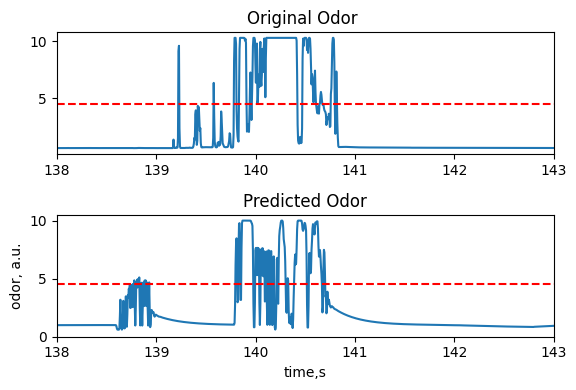

In [476]:
f,(ax1,ax2)= plt.subplots(2,1,figsize=(6,4))
ax1.plot(df_test.time, df_test.odor, label='original')
ax2.plot(df_test.time, df_test.predicted_odor, label='predicted')
ax1.axhline(4.5, color = 'r', linestyle = '--')
ax2.axhline(4.5, color = 'r', linestyle = '--')
limit = (138,143)
ax1.set_xlim(limit)
ax2.set_xlim(limit)

# ax2.set_ylim(0,11)
ax2.set_ylabel('odor, a.u.')
ax2.set_xlabel('time,s')
ax1.set_title('Original Odor ')
ax2.set_title('Predicted Odor')
f.tight_layout()

In [446]:
# df_test.loc[(df_test['time'] >= 120) & (df_test['time'] <= 122), 'odor'].mean()

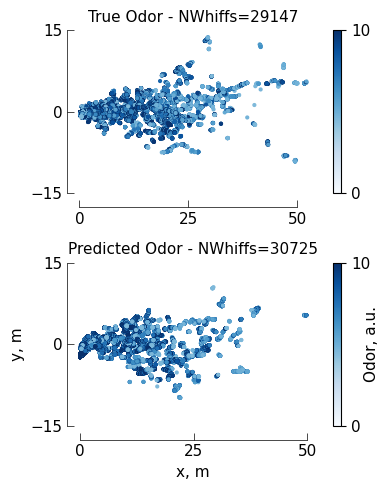

In [447]:
f, ax = plt.subplots(2, 1, figsize=(4, 5))

cax1 = ax[0].scatter(new_test_df1.distance_along_streakline, new_test_df1.nearest_from_streakline, c=new_test_df1.odor, s = 4, cmap='Blues', vmin=0, vmax=10)
cax2 = ax[1].scatter(new_test_df2.distance_along_streakline, new_test_df2.nearest_from_streakline, c=new_test_df2.predicted_odor, s = 4, cmap='Blues', vmin=0, vmax=10)
ax[0].set_title('True Odor - NWhiffs='+str(len(new_test_df1)))
ax[1].set_title('Predicted Odor - NWhiffs='+str(len(new_test_df2)))
ax[1].set_xlabel('x, m')
ax[1].set_ylabel('y, m')
cb1=plt.colorbar(cax1)
cb2=plt.colorbar(cax2)
# cb1.set_label('Odor, a.u.',labelpad=-10)
cb2.set_label('Odor, a.u.',labelpad=-5)
cb1.set_ticks([0,10])
cb2.set_ticks([0,10])
for i in range(2):
    mpl_functions.adjust_spines(ax[i],['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[0,25,50],
                            yticks=[-15,0,15],
                            linewidth=0.5)
    mpl_functions.set_fontsize(ax[i],11)

f.tight_layout()

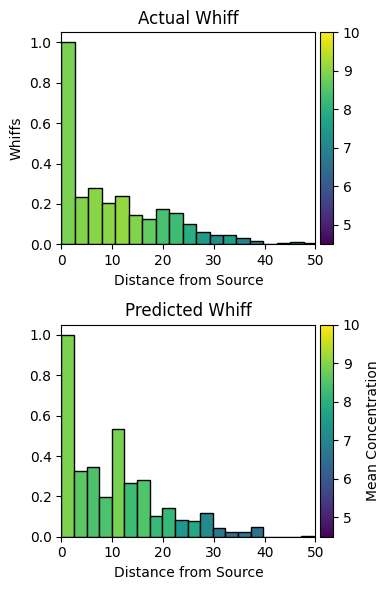

In [448]:
n_bins = 20

# Actual Whiff Data
df_actual = new_test_df1.copy()
bins = np.linspace(0, df_actual['distance_from_source'].max(), n_bins + 1)
df_actual['distance_bin'] = pd.cut(df_actual['distance_from_source'], bins=bins)

whiff_counts_actual = df_actual.groupby('distance_bin').size()
mean_concentrations_actual = df_actual.groupby('distance_bin')['odor'].mean()
bin_centers_actual = (bins[:-1] + bins[1:]) / 2

# Normalize actual whiff counts5
whiff_counts_actual_norm = whiff_counts_actual / whiff_counts_actual.max()

# Predicted Whiff Data
df_predicted = new_test_df2.copy()
bins_predicted = np.linspace(0, df_predicted['distance_from_source'].max(), n_bins + 1)
df_predicted['distance_bin'] = pd.cut(df_predicted['distance_from_source'], bins=bins_predicted)

whiff_counts_predicted = df_predicted.groupby('distance_bin').size()
mean_concentrations_predicted = df_predicted.groupby('distance_bin')['predicted_odor'].mean()
bin_centers_predicted = (bins_predicted[:-1] + bins_predicted[1:]) / 2

# Normalize predicted whiff counts
whiff_counts_predicted_norm = whiff_counts_predicted / whiff_counts_predicted.max()

# Create the subplots
f, ax = plt.subplots(2, 1, figsize=(4, 6))

# Plot for Actual Whiff Data
norm_actual = plt.Normalize(4.5, 10)
colors_actual = plt.cm.viridis(norm_actual(mean_concentrations_actual))
bars_actual = ax[0].bar(bin_centers_actual, whiff_counts_actual_norm, width=(bins[1] - bins[0]), edgecolor='black', color=colors_actual)

divider_actual = make_axes_locatable(ax[0])
cax_actual = divider_actual.append_axes("right", size="5%", pad=0.05)
sm_actual = plt.cm.ScalarMappable(cmap='viridis', norm=norm_actual)
sm_actual.set_array([])
cbar_actual = plt.colorbar(sm_actual, cax=cax_actual)

ax[0].set_xlabel('Distance from Source')
ax[0].set_ylabel('Whiffs')
ax[0].set_title('Actual Whiff')
# ax[0].set_ylim(0, 1)
ax[0].set_xlim(0, 50)

# Plot for Predicted Whiff Data
norm_predicted = plt.Normalize(4.5, 10)
colors_predicted = plt.cm.viridis(norm_predicted(mean_concentrations_predicted))
bars_predicted = ax[1].bar(bin_centers_predicted, whiff_counts_predicted_norm, width=(bins_predicted[1] - bins_predicted[0]), edgecolor='black', color=colors_predicted)

divider_predicted = make_axes_locatable(ax[1])
cax_predicted = divider_predicted.append_axes("right", size="5%", pad=0.05)
sm_predicted = plt.cm.ScalarMappable(cmap='viridis', norm=norm_predicted)
sm_predicted.set_array([])
cbar_predicted = plt.colorbar(sm_predicted, cax=cax_predicted)
cbar_predicted.set_label('Mean Concentration')

ax[1].set_xlabel('Distance from Source')
ax[1].set_title('Predicted Whiff')
# ax[1].set_ylim(0, 1)
ax[1].set_xlim(0, 50)

f.tight_layout()



In [449]:
new_test_df1=df_test.copy()
new_test_df2=df_test.copy()

In [450]:
def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 4.5
np.seterr(divide='ignore')
index = osc.get_index(new_test_df1.odor,th)
index_predicted = osc.get_index(new_test_df2.predicted_odor,th)
fdf1 = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df1,index,fdf1)
cal_stat_predicted(new_test_df2,index_predicted, fdf_predicted)

fdf1.keys()

/home/gorilla/An/plume_sim/odor_stat_calculations.py:229: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

In [477]:
df_test.to_hdf('../data/simulator/plot/hws_dec28_3.h5', mode='w', key='df_test')
# fdf_predicted.to_hdf('../data/simulator/plot/odor_pr_stat.h5', mode='w', key='fdf_predicted')

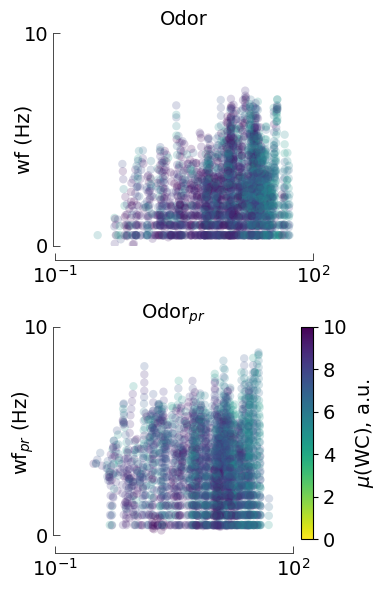

In [452]:
### WHIFF FREQUENCY5
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.wf, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)
ax1.set_ylabel('Whiff Frequency (Hz)')

# g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.wf, data=fdf1,
#                  ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
# g1.set(xlabel=None, ylabel=None)
ax1.set_ylim(0,)
ax1.set_title('Odor')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

# g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.wf, data=fdf_predicted,
#                  ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
ax2.set_title('Odor$_{pr}$')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
ax1.set_ylabel('wf (Hz)')
ax2.set_ylabel('wf$_{pr}$ (Hz)')

# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-1, 2],
                            yticks=[0, 10],                                    
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-1, 2],
                            yticks=[0, 10],
                            linewidth=0.5)

ax1.set_ylim(0,)

# Set custom tick labels
# ax1.set_yticklabels([r'$0$', r'$10$'])
ax1.set_xticklabels([r'$10^{-1}$', r'$10^{2}$'])
# ax2.set_yticklabels([r'$0$', r'$10$'])
ax2.set_xticklabels([r'$10^{-1}$', r'$10^{2}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 9709.33it/s]


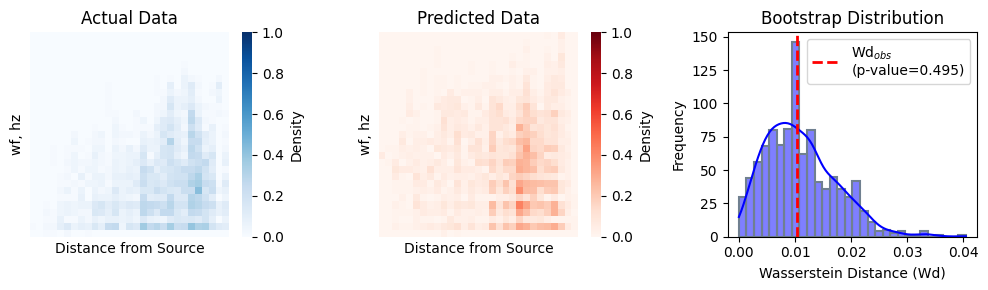

In [453]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.wf, fdf_predicted.log_avg_dist_from_source, fdf_predicted.wf, 'wf, hz', 0,1)

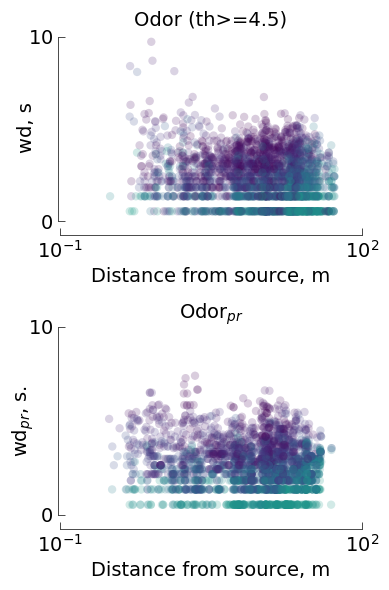

In [454]:
### WHIFF DURATION
f,(ax1,ax2)=plt.subplots(2,1,figsize=(4,6))
var = ax1.scatter(fdf1.log_avg_dist_from_source,fdf1.log_whiff, c=fdf1.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2,vmin=0,vmax=10  )
ax1.set_ylabel('$\mu$(WC), a.u.')

# g1 = sns.regplot(x=fdf1.log_avg_dist_from_source,y=fdf1.log_whiff , data=fdf1,
#             ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source, m')
ax1.set_ylabel('wd, s')
ax1.set_title('Odor (th>='+str(th)+')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

u=ax2.scatter(fdf_predicted.log_avg_dist_from_source,
              fdf_predicted.log_whiff, c=fdf_predicted.mean_concentration, cmap='viridis_r',edgecolors='none', 
                 alpha=0.2, vmin=0,vmax=10)

# g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
#             ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
# g2.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax2)
# cax1 = divider.append_axes('right', size='5%', pad=0.08)
# cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
# cbar1.solids.set(alpha=1)
# cbar1.set_label('$\mu$(Odor), a.u.')

ax2.set_xlabel('Distance from source, m')
ax2.set_title('Odor$_{pr}$')
ax2.set_ylabel('wd$_{pr}$, s.')
ax2.yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.adjust_spines(ax1,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[-1,2],
                            yticks=[-2.5,1.2],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2,['left','bottom'],
                            spine_locations={'left': 1}, 
                            smart_bounds=True,
                            xticks=[-1,2],
                            yticks=[-2.5,1.2],
                            linewidth=0.5)
ax1.set_yticklabels([r'$0$', r'$10$'])
ax1.set_xticklabels([r'$10^{-1}$', r'$10^{2}$'])
ax2.set_yticklabels([r'$0$', r'$10$'])
ax2.set_xticklabels([r'$10^{-1}$', r'$10^{2}$'])


mpl_functions.set_fontsize(f, 14)
f.tight_layout()


100%|██████████| 1000/1000 [00:00<00:00, 8943.57it/s]


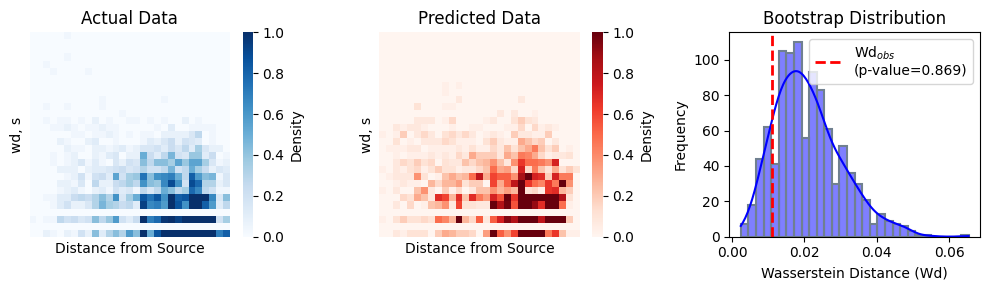

In [455]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.log_whiff, fdf_predicted.log_avg_dist_from_source, fdf_predicted.log_whiff, 'wd, s', 0,1)

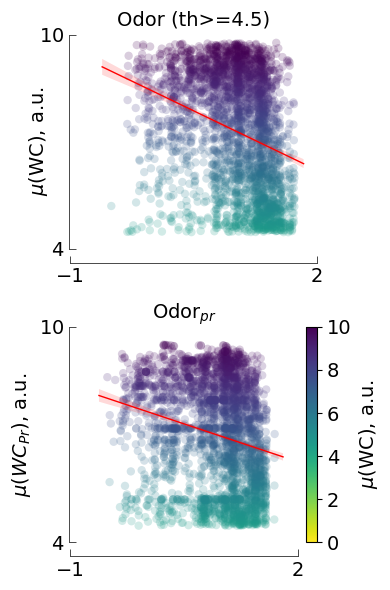

In [456]:
### Whiff concentration
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6))

# Plot for actual odor
var1 = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.mean_concentration, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                   alpha=0.2, vmin=0, vmax=10)


g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.mean_concentration, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes('right', size='5%', pad=0.08)
# cbar = f.colorbar(var1, cax=cax, orientation='vertical')
# cbar.solids.set(alpha=1)
# cbar.set_label('$\mu$(WC), a.u.')

# ax1.set_xlabel('Distance from source (log), m')
ax1.set_title('Odor (th>=' + str(th) + ')')
ax1.yaxis.set_label_coords(-0.08, 0.5)

# Plot for predicted odor
var2 = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.mean_concentration, c=fdf_predicted.mean_concentration,
                   cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.mean_concentration, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var2, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# ax2.set_xlabel('Distance from source (log), m')
ax2.set_title('Odor$_{pr}$')
ax1.set_ylabel('$\mu$(WC), a.u.')
ax2.set_ylabel('$\mu(WC_{Pr})$, a.u.')
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-1, 2],
                            yticks=[4, 10.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-1, 2],
                            yticks=[4, 10.5],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$4$', r'$10$'])
# ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$4$', r'$10$'])
# ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 9199.59it/s]


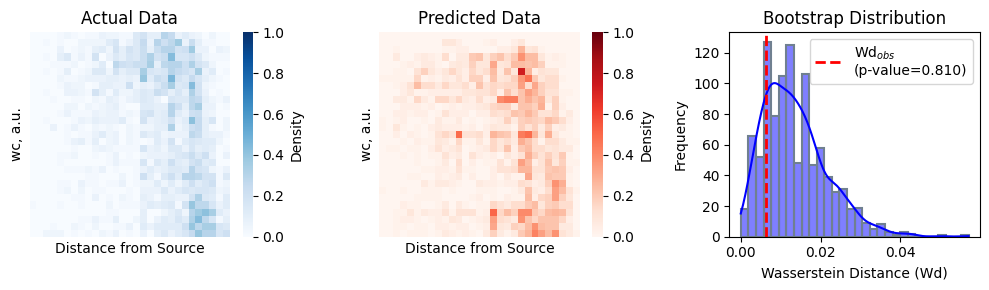

In [457]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.mean_concentration, fdf_predicted.log_avg_dist_from_source, fdf_predicted.mean_concentration, 'wc, a.u.', 0,1)

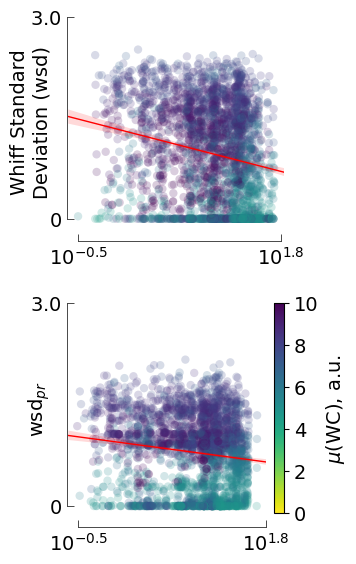

In [458]:
### WHIFF STANDARD DEVIATION
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.std_whiff, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.std_whiff, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# Remove color bar for the actual odor plot
# ax1.set_xlabel('Distance from source (log), m')
# ax1.set_title('Actual Odor (th>=' + str(th) + ')')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.std_whiff, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.std_whiff, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
# ax2.set_title('Predicted Odor')
ax1.set_ylabel('Whiff Standard\nDeviation (wsd)')
ax2.set_ylabel('wsd$_{pr}$')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-0.5, 1.8],
                            yticks=[0, 3.0],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-0.5, 1.8],
                            yticks=[0, 3.0],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$3.0$'])
ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax2.set_yticklabels([r'$0$', r'$3.0$'])
ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout(pad=2)


100%|██████████| 1000/1000 [00:00<00:00, 8169.25it/s]


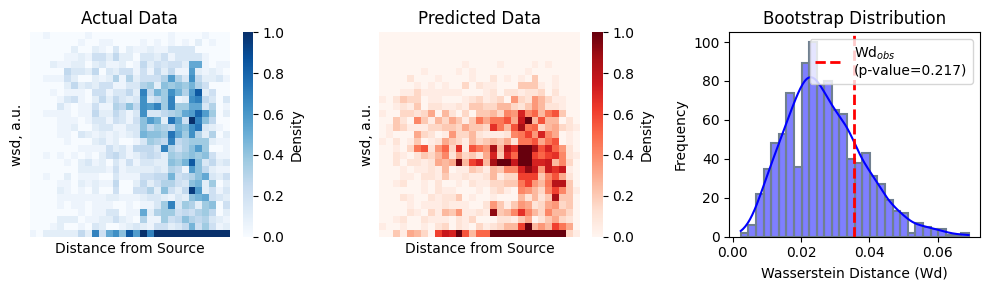

In [459]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.std_whiff, fdf_predicted.log_avg_dist_from_source, fdf_predicted.std_whiff, 'wsd, a.u.', 0,1)

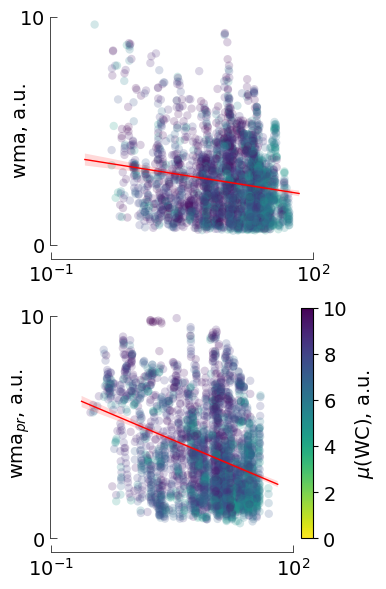

In [460]:
### WHIFF MOVING AVERAGE
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 6))

# Plot for actual odor
var = ax1.scatter(fdf1.log_avg_dist_from_source, fdf1.whiff_ma, c=fdf1.mean_concentration, cmap='viridis_r', edgecolors='none',
                  alpha=0.2, vmin=0, vmax=10)
ax1.set_ylabel('Whiff Moving Average (wma)')

g1 = sns.regplot(x=fdf1.log_avg_dist_from_source, y=fdf1.whiff_ma, data=fdf1,
                 ax=ax1, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

# Remove color bar for the actual odor plot
# ax1.set_xlabel('Distance from source (log)20, m')
# ax1.set_title('Actual Odor (th>=' + str(th) + ')')

# Plot for predicted odor
u = ax2.scatter(fdf_predicted.log_avg_dist_from_source, fdf_predicted.whiff_ma, c=fdf_predicted.mean_concentration,
                cmap='viridis_r', edgecolors='none', alpha=0.2, vmin=0, vmax=10)

g2 = sns.regplot(x=fdf_predicted.log_avg_dist_from_source, y=fdf_predicted.whiff_ma, data=fdf_predicted,
                 ax=ax2, line_kws={'color': 'red', 'linewidth': 1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

# Add color bar only for the predicted odor plot
divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(u, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set the titles and labels
# ax2.set_title('Predicted Odor')
ax1.set_ylabel('wma, a.u.')
ax2.set_ylabel('wma$_{pr}$, a.u.')
ax1.yaxis.set_label_coords(-0.08, 0.5)
ax2.yaxis.set_label_coords(-0.08, 0.5)
# Adjust spines for both plots
mpl_functions.adjust_spines(ax1, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-1, 2],
                            yticks=[0, 10.5],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax2, ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[-1, 2],
                            yticks=[0, 10],
                            linewidth=0.5)

# Set custom tick labels
ax1.set_yticklabels([r'$0$', r'$10$'])
ax1.set_xticklabels([r'$10^{-1}$', r'$10^{2}$'])
ax2.set_yticklabels([r'$0$', r'$10$'])
ax2.set_xticklabels([r'$10^{-1}$', r'$10^{2}$'])

# Set font size and layout
mpl_functions.set_fontsize(f, 14)
f.tight_layout()


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 9719.32it/s]


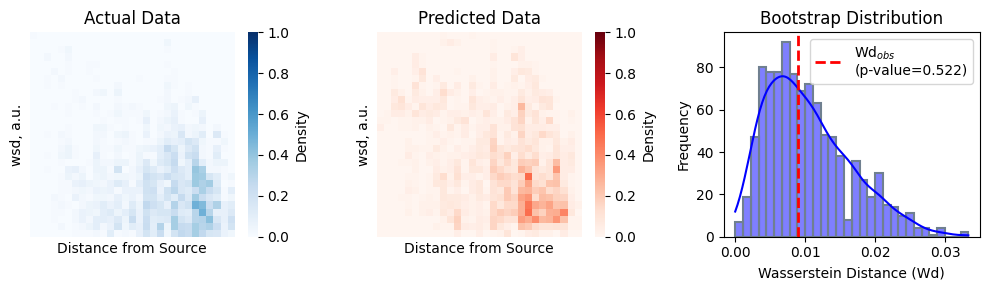

In [461]:
osc.wd_cal(fdf1.log_avg_dist_from_source, fdf1.whiff_ma, fdf_predicted.log_avg_dist_from_source, fdf_predicted.whiff_ma, 'wsd, a.u.', 0,1)

In [162]:
# df_test.to_hdf('../data/simulator/plot/hws.h5', key='df_test', mode='w')
# fdf1.to_hdf('../data/simulator/plot/odor_stat.h5', key='df_test', mode='w')
# fdf_predicted.to_hdf('../data/simulator/plot/odor_pr_stat.h5', key='df_test', mode='w')

In [163]:
import statsmodels.formula.api as smf

def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 5, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 5)  & (dataframe.avg_dist_from_source < 30), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 30, 'type'] = 2
    return dataframe

fdf_new = create_class_column(fdf1)
fdf_predicted_new = create_class_column(fdf_predicted)

In [164]:
lookback_time = 10
trainset = fdf_new

D_train = []
mean_time_train = []
Xtrain = []
ytrain = []
Nrows_train = []

# Loop through distance classes, using the modified functions
for distance_class in [0, 1, 2]:
    Xtrain, ytrain, D_train, Nrows_train, mean_time_train = osc.gather_stat_timed(
        trainset, distance_class, lookback_time, Xtrain, ytrain, D_train, Nrows_train, mean_time_train)

# Calculate statistical values
def calc_val(X):
    return np.ravel([np.min(X), np.max(X), np.mean(X), np.std(X), kurtosis(X)])

# Create a DataFrame to store the results
column_names = ['mc_min', 'mc_max', 'mc_mean', 'mc_std_dev', 'mc_k',
                'wf_min', 'wf_max', 'wf_mean', 'wf_std_dev', 'wf_k',
                'wd_min', 'wd_max', 'wd_mean', 'wd_std_dev', 'wd_k',
                'ma_min', 'ma_max', 'ma_mean', 'ma_std_dev', 'ma_k',
                'st_min', 'st_max', 'st_mean', 'st_std_dev', 'st_k']

traindf = pd.DataFrame(columns=column_names)
c1 = []

# Populate the DataFrame with the smoothed and consistent stats
for i in range(len(Xtrain)):
    if np.size(Xtrain[i]) == 0:
        c1.append(i)
        continue
    else:
        X = []
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf.loc[i] = np.ravel(X)

# Add additional columns for distance, mean whiff time, and number of whiffs
traindf['distance'] = np.delete(D_train, c1)
traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
traindf['nwhiffs'] = np.delete(Nrows_train, c1)

/tmp/ipykernel_884690/627185542.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X), np.max(X), np.mean(X), np.std(X), kurtosis(X)])
/tmp/ipykernel_884690/627185542.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X), np.max(X), np.mean(X), np.std(X), kurtosis(X)])
/tmp/ipykernel_884690/627185542.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X), np.max(X), np.mean(X), np.std(X), kurtosis(X)])
/tmp/ipykernel_884690/627185542.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. T

In [165]:
# traindf.to_hdf('../data/simulator/plot/odor_lt_stat.h5', key='df_test', mode='w')

In [166]:
distance=smf.ols(formula=""" distance ~ mc_mean + ma_std_dev + ma_max + wd_std_dev """, data=traindf).fit()
print(distance.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     814.6
Date:                Mon, 23 Dec 2024   Prob (F-statistic):               0.00
Time:                        09:39:58   Log-Likelihood:                -5035.0
No. Observations:                1418   AIC:                         1.008e+04
Df Residuals:                    1413   BIC:                         1.011e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     98.0058      1.422     68.939      0.0

In [167]:
lookback_time = 10

trainset_predicted= fdf_predicted_new

D_train_predicted=[]
mean_time_train_predicted=[]
Xtrain_predicted = []
ytrain_predicted = []
predictions_filled = []
mean_time_train_predicted = []
Nrows_train_predicted = []

for distance_class in [0,1,2]:
    Xtrain_predicted, ytrain_predicted, D_train_predicted, Nrows_train_predicted , mean_time_train_predicted = osc.gather_stat_timed(trainset_predicted, distance_class,
                      lookback_time, Xtrain_predicted, ytrain_predicted, D_train_predicted, Nrows_train_predicted,
                      mean_time_train_predicted)
    
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

traindf_predicted=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain_predicted)):
    if(np.size(Xtrain_predicted[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain_predicted[i])):
            X.append(calc_val(Xtrain_predicted[i][j]))
        traindf_predicted.loc[i]=np.ravel(X)
        
traindf_predicted['distance']=np.delete(D_train_predicted, c1)
traindf_predicted['mean_whiff_time'] = np.delete(mean_time_train_predicted, c1)
traindf_predicted['nwhiffs'] = np.delete(Nrows_train_predicted, c1)

/tmp/ipykernel_884690/975394852.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_884690/975394852.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_884690/975394852.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_884690/975394852.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs w

In [168]:
# traindf_predicted.to_hdf('../data/simulator/plot/odor_pr_lt_stat.h5', key='df_test', mode='w')

In [169]:
distance=smf.ols(formula=""" distance ~ mc_mean + ma_std_dev + ma_max + wd_std_dev """, data=traindf_predicted).fit()
print(distance.summary())

                            OLS Regression Results                            
Dep. Variable:               distance   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     443.4
Date:                Mon, 23 Dec 2024   Prob (F-statistic):          1.04e-246
Time:                        09:40:03   Log-Likelihood:                -5161.6
No. Observations:                1401   AIC:                         1.033e+04
Df Residuals:                    1396   BIC:                         1.036e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     66.1326      1.741     37.992      0.0

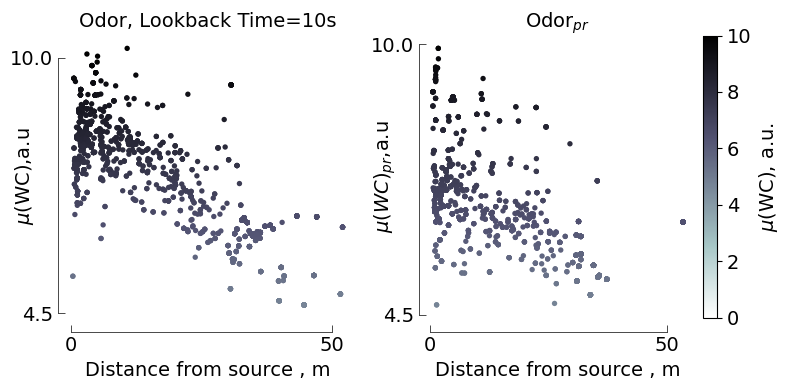

In [170]:
## whiff concentration
f,ax = plt.subplots(1,2,figsize=(8,4))
var1 =ax[0].scatter(traindf.distance, traindf.mc_mean, c=traindf.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# divider = make_axes_locatable(ax[0])
# cax1 = divider.append_axes('right', size='5%', pad=0.08)
# cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
# cbar1.solids.set(alpha=1)
# cbar1.set_label('$\mu$(WC), a.u.')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf,
#             ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.mc_mean,c=traindf_predicted.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)

cbar1.set_label('$\mu$(WC), a.u.')
# ax[1].set_ylabel('$\mu$(WC)_predicted, a.u.')
ax[0].set_ylabel('$\mu$(WC),a.u')
ax[1].set_ylabel('$\mu(WC)_{pr}$,a.u')
ax[0].set_xlabel('Distance from source , m')
ax[1].set_xlabel('Distance from source , m')

ax[0].set_title('Odor, Lookback Time=10s')
ax[1].set_title('Odor$_{pr}$')

mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[4.5, 10],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax[1], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[4.5,10],
                            linewidth=0.5)
ax[0].yaxis.set_label_coords(-0.08, 0.5)
ax[1].yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.set_fontsize(f, 14)
f.tight_layout()


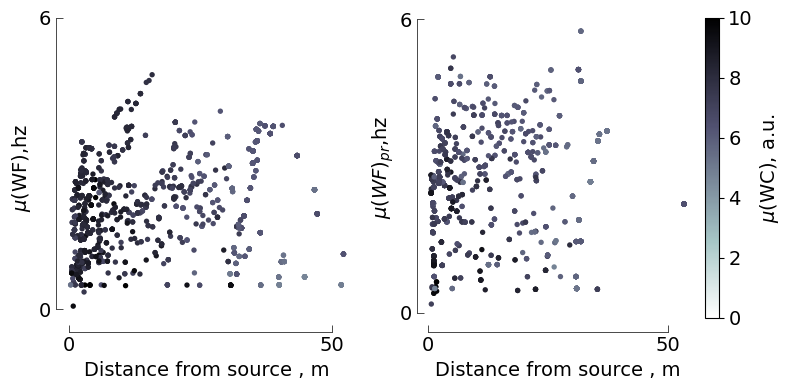

In [171]:
f,ax = plt.subplots(1,2,figsize=(8,4))
var1 =ax[0].scatter(traindf.distance, traindf.wf_mean, c=traindf.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# divider = make_axes_locatable(ax[0])
# cax1 = divider.append_axes('right', size='5%', pad=0.08)
# cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
# cbar1.solids.set(alpha=1)
# cbar1.set_label('$\mu$(WC), a.u.')

# g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf,
#             ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

# g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.wf_mean,c=traindf_predicted.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
#             ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)

cbar1.set_label('$\mu$(WC), a.u.')
# ax[1].set_ylabel('$\mu$(WC)_predicted, a.u.')
ax[0].set_ylabel('$\mu$(WF),hz')
ax[1].set_ylabel('$\mu(WF)_{pr}$,hz')
ax[0].set_xlabel('Distance from source , m')
ax[1].set_xlabel('Distance from source , m')

# ax[0].set_title('Odor, Lookback Time=10s')
# ax[1].set_title('Odor$_{pr}$')

mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[0,6],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax[1], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0,50],
                            yticks=[0,6],
                            linewidth=0.5)
ax[0].yaxis.set_label_coords(-0.08, 0.5)
ax[1].yaxis.set_label_coords(-0.08, 0.5)
mpl_functions.set_fontsize(f, 14)
f.tight_layout()

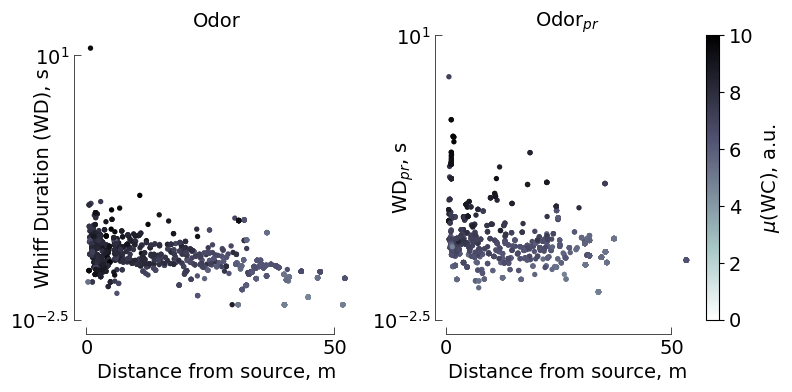

In [172]:
## WHIFF DURATION
f, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual whiff duration
var1 = ax[0].scatter(traindf.distance, traindf.wd_mean, c=traindf.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# Plot for predicted whiff duration
var2 = ax[1].scatter(traindf_predicted.distance, traindf_predicted.wd_mean, c=traindf_predicted.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# Add color bar for the predicted plot only
divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var2, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set labels and titles
ax[0].set_ylabel('Whiff Duration (WD), s')
ax[1].set_ylabel('WD$_{pr}$, s')
ax[0].set_xlabel('Distance from source, m')
ax[1].set_xlabel('Distance from source, m')
ax[0].set_title('Odor')
ax[1].set_title('Odor$_{pr}$')

# Adjust spines for both plots
mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[-2.5, 1.0],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax[1], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[-2.5, 1.0],
                            linewidth=0.5)

# Adjust label positions
ax[0].yaxis.set_label_coords(-0.08, 0.5)
ax[1].yaxis.set_label_coords(-0.08, 0.5)

ax[0].set_yticklabels([r'$10^{-2.5}$', r'$10^{1}$'])
# ax1.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])
ax[1].set_yticklabels([r'$10^{-2.5}$', r'$10^{1}$'])
# ax2.set_xticklabels([r'$10^{-0.5}$', r'$10^{1.8}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout(pad=1)


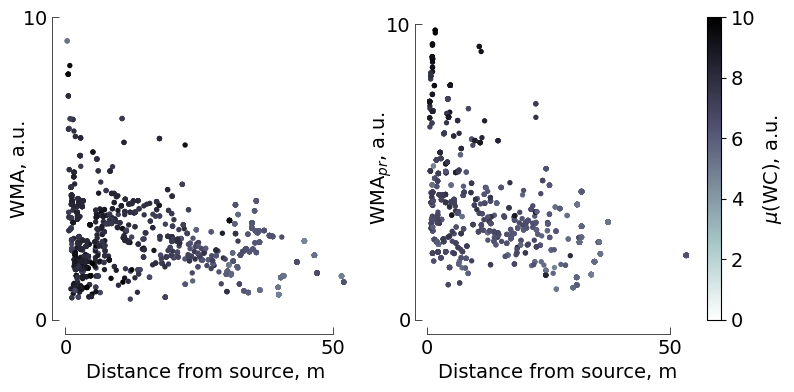

In [173]:
## WHIFF MOVING AVERAGE (WMA)
f, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual WMA
var1 = ax[0].scatter(traindf.distance, traindf.ma_mean, c=traindf.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# Plot for predicted WMA
var2 = ax[1].scatter(traindf_predicted.distance, traindf_predicted.ma_mean, c=traindf_predicted.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# Add color bar for the predicted plot only
divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var2, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set labels and titles
ax[0].set_ylabel('WMA, a.u.')
ax[1].set_ylabel('WMA$_{pr}$, a.u.')
ax[0].set_xlabel('Distance from source, m')
ax[1].set_xlabel('Distance from source, m')
# ax[0].set_title('Odor')
# ax[1].set_title('Odor$_{pr}$')

# Adjust spines for both plots
mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0,11],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax[1], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0,10],
                            linewidth=0.5)

# Adjust label positions
ax[0].yaxis.set_label_coords(-0.08, 0.5)
ax[1].yaxis.set_label_coords(-0.08, 0.5)
ax[0].set_yticklabels([r'$0$', r'$10$'])
# ax[0].set_yticklabels([r'$10^{-2.5}$', r'$10^{1}$'])
# ax[1].set_yticklabels([r'$10^{-2.5}$', r'$10^{1}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout(pad=1)
plt.show()


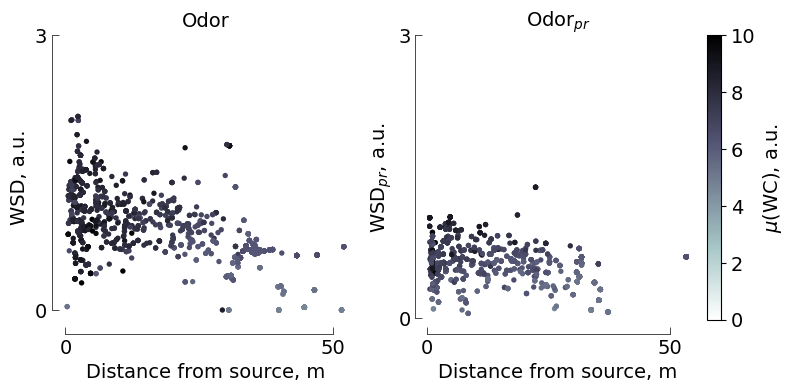

In [174]:
## WHIFF STANDARD DEVIATION (WSD)
f, ax = plt.subplots(1, 2, figsize=(8, 4))

# Plot for actual WSD
var1 = ax[0].scatter(traindf.distance, traindf.st_mean, c=traindf.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# Plot for predicted WSD
var2 = ax[1].scatter(traindf_predicted.distance, traindf_predicted.st_mean, c=traindf_predicted.mc_mean, cmap='bone_r', edgecolors='none', s=15, vmin=0, vmax=10)

# Add color bar for the predicted plot only
divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1 = f.colorbar(var2, cax=cax1, orientation='vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')

# Set labels and titles
ax[0].set_ylabel('WSD, a.u.')
ax[1].set_ylabel('WSD$_{pr}$, a.u.')
ax[0].set_xlabel('Distance from source, m')
ax[1].set_xlabel('Distance from source, m')
ax[0].set_title('Odor')
ax[1].set_title('Odor$_{pr}$')

# Adjust spines for both plots
mpl_functions.adjust_spines(ax[0], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0,3],
                            linewidth=0.5)
mpl_functions.adjust_spines(ax[1], ['left', 'bottom'],
                            spine_locations={'left': 1},
                            smart_bounds=True,
                            xticks=[0, 50],
                            yticks=[0,3],
                            linewidth=0.5)

# Adjust label positions
ax[0].yaxis.set_label_coords(-0.08, 0.5)
ax[1].yaxis.set_label_coords(-0.08, 0.5)

# ax[0].set_yticklabels([r'$10^{-2.5}$', r'$10^{1}$'])
# ax[1].set_yticklabels([r'$10^{-2.5}$', r'$10^{1}$'])

mpl_functions.set_fontsize(f, 14)
f.tight_layout(pad=1)
plt.show()


In [ ]:
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Tuple
from scipy.spatial.distance import cdist

def logit(x, lower=0.0, upper=10.0, eps=1e-8):
    """
    Convert x in [lower, upper] to an unbounded real z in (-inf, +inf).
    We clamp x slightly to avoid taking log(0).
    """
    x_clamped = np.clip(x, lower + eps, upper - eps)
    scale = upper - lower
    ratio = (x_clamped - lower) / scale
    return np.log(ratio / (1 - ratio))

def inv_logit(z, lower=0.0, upper=10.0):
    """
    Convert an unbounded real z in (-inf, +inf) back to [lower, upper].
    """
    scale = upper - lower
    return lower + scale / (1.0 + np.exp(-z))

class OdorStateManager:
    def __init__(self, config, whiff_intermittency):
        # Start odor at base level, but store internally in z-space
        z_init = logit(config.base_odor_level, 0, 10)
        self.z_current = z_init
        self.z_prev = z_init

        # For reference/tracking we also keep actual odor in [0..10]
        # (initialized to the base_odor_level).
        self.current_concentration = config.base_odor_level
        self.prev_concentration = config.base_odor_level

        # For other state logic
        self.recent_history = [0] * 1000
        self.recent_concentrations = [config.base_odor_level] * 10
        self.recent_intermittencies = list(np.random.choice(whiff_intermittency, 5))
        self.in_whiff_state = False
        self.state_duration = 0

@dataclass
class OdorConfig:
    rows_per_second: int = 200
    base_odor_level: float = 0.70
    distance_threshold: float = 3
    ar1: float = 0.98
    ar2: float = -0.02
    warmup_steps: int = 1000
    low_threshold: float = 0.05
    history_length: int = 7
    transition_matrix: np.ndarray = np.array([[0.15, 0.85],
                                              [0.15, 0.85]])

class ParallelOdorPredictor:
    def __init__(self, df_test: pd.DataFrame, fdf: pd.DataFrame, fdf_nowhiff: pd.DataFrame):
        self.config = OdorConfig()
        self.df_test = df_test
        self.fdf = fdf
        self.fdf_nowhiff = fdf_nowhiff
        self.setup_data()

    def setup_data(self):
        distance_bins = np.arange(0, 60, 15)
        self.bin_data_dict = {}
        for i in range(len(distance_bins) - 1):
            start_dist, end_dist = distance_bins[i], distance_bins[i + 1]
            bin_data = self.fdf[
                (self.fdf['avg_distance_along_streakline'] >= start_dist) &
                (self.fdf['avg_distance_along_streakline'] < end_dist)
            ]['odor_intermittency'].dropna().values
            self.bin_data_dict[(start_dist, end_dist)] = bin_data

    @staticmethod
    def calculate_distance_from_source(x: float, y: float) -> float:
        return np.sqrt(x**2 + y**2)

    def generate_intermittency(self, distance: float,
                               state: OdorStateManager,
                               default: float = 0.05) -> float:
        """
        Sample an 'odor_intermittency' value from the data distribution,
        with some biasing logic based on recent low-values.
        """
        last_values = np.array(state.recent_intermittencies[-self.config.history_length:])
        low_frequency = np.mean(last_values < self.config.low_threshold)

        for (sd, ed), values in self.bin_data_dict.items():
            if sd <= distance < ed and len(values) > 0:
                if low_frequency > 0.5:
                    # Bias sampling toward the lower half of the bin
                    median_val = np.median(values)
                    subset = values[values < median_val]
                    if len(subset) > 0:
                        intermittency = np.random.choice(subset)
                    else:
                        intermittency = np.random.choice(values)
                else:
                    # Normal sampling
                    intermittency = np.random.choice(values)
                # Keep it in the observed range
                return np.clip(intermittency, np.min(values), np.max(values))
        return default

    def update_whiff_posterior(self, prior_prob: float, state: OdorStateManager) -> float:
        """
        Example function to incorporate a Markov chain / state transition
        plus some heuristics about recent whiffs, etc.
        """
        whiff_state = 1 if state.in_whiff_state else 0
        num_recent_whiffs = sum(state.recent_history[-20:])

        # Time since last whiff
        time_since_whiff = 0
        for i in range(len(state.recent_history) - 1, -1, -1):
            if state.recent_history[i]:
                break
            time_since_whiff += 1

        # Heuristics that boost or reduce whiff probability
        time_factor = min(1.5, time_since_whiff / 35) if time_since_whiff > 50 else 1.0
        boost_factor = (1 + (num_recent_whiffs / 30) * 0.3) * time_factor

        # Another factor from recent concentrations
        recent_avg_concentration = np.mean(state.recent_concentrations[-10:])
        ar_factor = max(0, (recent_avg_concentration - self.config.base_odor_level) /
                        (4.5 - self.config.base_odor_level))
        concentration_factor = np.clip(1 + ar_factor * 0.2, 0.6, 1.4)

        # Basic Markov chain transition
        posterior = ((prior_prob * 0.2)
                     * self.config.transition_matrix[whiff_state][1]
                     * boost_factor
                     * concentration_factor)

        # Normalize
        return posterior / (posterior + (1 - posterior))

    def update_ar2_unified(self, odor_current: float, odor_prev: float, odor_target: float,
                           distance: float, range_lower: float, range_upper: float,
                           base_noise_scale: float = 0.1, jump_prob: float = 0.05) -> float:
        z_current = logit(odor_current, lower=range_lower, upper=range_upper)
        z_prev = logit(odor_prev, lower=range_lower, upper=range_upper)
        z_target = logit(odor_target, lower=range_lower, upper=range_upper)

        distance_factor = np.exp(-distance / 50.0)
        ar1_local = self.config.ar1 * (1 + 0.1 * distance_factor)
        ar2_local = self.config.ar2 * (1 - 0.1 * distance_factor)
        noise = base_noise_scale * (1 + 2 * distance_factor) * np.random.randn()

        if np.random.rand() < jump_prob:
            jump_size = np.random.uniform(-1, 1) * base_noise_scale * 3
            noise += jump_size

        z_next = 0.85 * (ar1_local * (z_current - z_target) +
                         ar2_local * (z_prev - z_target)) + z_target + noise

        odor_next = inv_logit(z_next, lower=range_lower, upper=range_upper)
        return odor_next

    def process_segment(self, start_idx: int, end_idx: int, state: OdorStateManager) -> Tuple[np.ndarray, np.ndarray]:
        segment = self.df_test.iloc[start_idx:end_idx]
        concentrations = np.full(len(segment), self.config.base_odor_level)
        predictions = np.zeros(len(segment), dtype=int)

        test_locations = segment[['distance_along_streakline', 'nearest_from_streakline']].values
        whiff_locations = self.fdf[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values
        nowhiff_locations = self.fdf_nowhiff[['avg_distance_along_streakline', 'avg_nearest_from_streakline']].values

        distances_from_source = np.array([
            self.calculate_distance_from_source(x, y) for x, y in test_locations
        ])
        distances = cdist(test_locations, whiff_locations)
        distances_nowhiff = cdist(test_locations, nowhiff_locations)

        i = 0
        while i < len(segment):
            if start_idx + i < self.config.warmup_steps:
                i += 1
                continue

            prior_prob = segment.spatial_prob.iloc[i]
            posterior = self.update_whiff_posterior(prior_prob, state)

            if state.in_whiff_state:
                state.state_duration += 1
                min_duration = 0.1 * self.config.rows_per_second
                if state.state_duration > min_duration:
                    continue_prob = 0.5 * prior_prob
                    state.in_whiff_state = (np.random.rand() < continue_prob)
            else:
                concentration_factor = (state.current_concentration - self.config.base_odor_level) / \
                                       (4.5 - self.config.base_odor_level)
                transition_prob = posterior * (1 + max(0, concentration_factor) * 0.3)
                state.in_whiff_state = (np.random.rand() < transition_prob * 0.5)
                if state.in_whiff_state:
                    state.state_duration = 0

            if state.in_whiff_state and (np.min(distances[i]) <= self.config.distance_threshold):
                nearest_idx = np.argmin(distances[i])
                mean_concentration = self.fdf.mean_concentration.values[nearest_idx]
                std_dev_whiff = self.fdf.std_whiff.values[nearest_idx]
                duration = int(self.fdf.length_of_encounter.values[nearest_idx] *
                               self.config.rows_per_second)
                rows_to_fill = min(duration, len(segment) - i)

                for j in range(rows_to_fill):
                    dist_here = distances_from_source[i + j] if (i + j) < len(distances_from_source) else 0
                    odor_next = self.update_ar2_unified(
                        odor_current=state.current_concentration,
                        odor_prev=state.prev_concentration,
                        odor_target=mean_concentration,
                        distance=dist_here,
                        range_lower=0.0,
                        range_upper=10.0,
                        base_noise_scale=0.15 * std_dev_whiff,
                        jump_prob=0.05
                    )

                    state.z_prev = state.z_current
                    state.z_current = logit(odor_next, 0, 10)
                    state.prev_concentration = state.current_concentration
                    state.current_concentration = odor_next

                    concentrations[i + j] = odor_next
                    predictions[i + j] = 1

                    state.recent_concentrations.append(odor_next)
                    state.recent_concentrations.pop(0)
                    state.recent_history.append(1)
                    state.recent_history.pop(0)

                i += rows_to_fill
                dist_along = segment.distance_along_streakline.iloc[i - 1]
                intermittency = self.generate_intermittency(dist_along, state)
                state.recent_intermittencies.append(intermittency)
                state.recent_intermittencies.pop(0)

                intermittency_duration = int(intermittency * self.config.rows_per_second * 0.9)
                i += intermittency_duration

            else:
                nearest_idx = np.argmin(distances_nowhiff[i])
                no_whiff_mean = self.fdf_nowhiff.wc_nowhiff.values[nearest_idx]
                no_whiff_std = self.fdf_nowhiff.wsd_nowhiff.values[nearest_idx]
                dist_here = distances_from_source[i]

                odor_next = self.update_ar2_unified(
                    odor_current=state.current_concentration,
                    odor_prev=state.prev_concentration,
                    odor_target=no_whiff_mean,
                    distance=dist_here,
                    range_lower=0.7,
                    range_upper=1.0,
                    base_noise_scale=0.05 * no_whiff_std,
                    jump_prob=0.0
                )

                if i >= 10:
                    window_data = np.append(concentrations[i - 10:i], odor_next)
                    ma = np.convolve(window_data, np.ones(10) / 10, mode='valid')[-1]
                    odor_next = ma

                state.z_prev = state.z_current
                state.z_current = logit(odor_next, 0.7, 1.0)
                state.prev_concentration = state.current_concentration
                state.current_concentration = odor_next

                concentrations[i] = odor_next
                state.recent_concentrations.append(odor_next)
                state.recent_concentrations.pop(0)
                state.recent_history.append(0)
                state.recent_history.pop(0)

                i += 1

        return concentrations, predictions

    # ------------------------------------
    # 3f) High-level driver
    # ------------------------------------
    def predict(self) -> pd.DataFrame:
        # We split data into segments so that state carries over between segments
        segment_size = 2000
        total_segments = (
            len(self.df_test) // segment_size +
            (1 if len(self.df_test) % segment_size else 0)
        )

        all_concentrations = []
        all_predictions = []

        # Create the state manager
        state = OdorStateManager(self.config, self.fdf.odor_intermittency.values)

        for seg_idx in range(total_segments):
            start_idx = seg_idx * segment_size
            end_idx   = min((seg_idx + 1) * segment_size, len(self.df_test))

            concentrations, predictions = self.process_segment(start_idx, end_idx, state)
            all_concentrations.append(concentrations)
            all_predictions.append(predictions)

        # Concatenate results
        final_concentrations = np.concatenate(all_concentrations)
        final_predictions = np.concatenate(all_predictions)

        # Optional: Post-processing for smoothing or matching distribution
        # Rolling statistics example
        window_size = 20
        rolling_std  = pd.Series(final_concentrations).rolling(window=window_size).std().fillna(method='bfill')
        rolling_mean = pd.Series(final_concentrations).rolling(window=window_size).mean().fillna(method='bfill')

        # Example "target" standard deviation shape (just as demonstration)
        distance_along = self.df_test.distance_along_streakline.values
        target_std_scale = np.exp(-distance_along / 50.0) * 1.5
        current_std_scale = rolling_std / (rolling_mean + 1e-6)
        adjustment_factor = np.clip(target_std_scale / (current_std_scale + 1e-6), 0.5, 2.0)

        # Adjust around rolling_mean
        adjusted_concentrations = rolling_mean + (final_concentrations - rolling_mean) * adjustment_factor
        # Because we use logistic updates, we generally *should* remain in [0,10].
        # But if the rolling adjustment pushes slightly out of range, do a minor clip:
        adjusted_concentrations = np.clip(adjusted_concentrations, 0, 10)

        # Final optional smoothing
        final_concentrations = gaussian_filter(adjusted_concentrations, sigma=0.8)

        # Store in df
        self.df_test['predicted_odor']    = final_concentrations
        self.df_test['whiff_predicted']   = final_predictions
        return self.df_test


# -----------------------------
# 4) Example usage in main()
# -----------------------------
def main():
    # Suppose df_test, fdf, fdf_nowhiff are already loaded
    # For demonstration, let’s just assume they exist as global or are imported

    predictor = ParallelOdorPredictor(df_test, fdf, fdf_nowhiff)
    result_df = predictor.predict()
    return result_df

if __name__ == "__main__":
    test_result = main()
    df_test['predicted_odor']  = test_result['predicted_odor']
    df_test['whiff_predicted'] = test_result['whiff_predicted']
